# Hands-on on Lattice Calculation in Python

*D. Gamba, A. Latina, A. Poyet, G. Sterbini, V. Ziemann*

[Introduction to Accelerator Physics, 18 September 1 October 2022, Kaunas, Lithuania](https://indico.cern.ch/event/1117526/)

# **NOTE: THIS VERSION HAS BEEN REVIEWED AFTER THE COURSE! CHECK ON INDICO FOR THE VERSION USED DURING THE COURSE!**

<p align="center">
<img src=./_img_exercises/upload_ccbdd4fe3ac855ffa79715fb09caac24.png width="80%">
</p>

## Introduction 

In this document we will present the suggested directions to solve the exercises of the "*Hands-on Lattice Calculations in Python*".
 
These solutions are a natural complement to the ["*Transverse Linear Beam Dynamics Primer using Python*"](./CAS_Optics_Primer.pdf) and will serve as a guidance for the student. Most of the time the result can be achieved using multiple paths and we encourage the student to explore them. 

**In addition, the goal is to stimulate the student's curiosity, so the simple exercise should be challenged to trigger more questions and to dive deeper into the physics of the problem.**

## Is your computer ready?

You received the [instructions](./Setup_Instructions.md) on how to prepare your python working environment.

**QUESTION: is everyone able to launch a jupyter lab server from her/his laptop?** 

**QUESTION: can you import the following packages without errors?** 


In [2]:
# numpy: our main numerical package
import numpy as np
# matplotlib and seaborn: our plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# linear algebra and optimisation algorithms
from numpy.linalg import norm
from scipy.optimize import minimize
# some useful package
from copy import deepcopy

# **Optional:** for animations you might need to configure your jupyter lab properly:
# > pip install ipywidgets
# > jupyter nbextension enable --py widgetsnbextension
# > jupyter labextension install @jupyter-widgets/jupyterlab-manager
from ipywidgets import interactive

### ... some other setup not to be bothered later

Let's also configure `matplotlib` for more presentation-friendly plot production

In [3]:
# some setup for the plotting
from matplotlib import pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## The Python Basics

lists, dictionaries, and numpy arrays...

In [226]:
# a list of object is defined with [], and element accessed with [idx]
my_list = [1,2,3,4]
print(f"The third element in my list is: {my_list[2]}")

# a list can contain any object, also another list to "fake" multi-dimensional arrays
my_list_of_lists = [[1,2,3,4],[5,6,7,8]]
print(f"A list of lists looks almost like a matrix:\n {my_list_of_lists}")

# a dictionary is defined with {}, and elements are accessed with ['key_value']
my_dictionary = {'a_key': 34, 'another_key': 'value as string', 3: 'value associated to an int key'}
print(f"The value associated to key 'a_key' in 'my_dictionary' is: {my_dictionary['a_key']}")

The third element in my list is: 3
A list of lists looks almost like a matrix:
 [[1, 2, 3, 4], [5, 6, 7, 8]]
The value associated to key 'a_key' in 'my_dictionary' is: 34


In [227]:
# a numpy array can be created from a list of numbers
my_2D_array = np.array(my_list_of_lists)
print(f"np.array is a nicer representation of matrices:\n {my_2D_array}")
print(f"First row, second column value is: {my_2D_array[0,1]}")
# or from a random generator
my_random_2D_array = np.random.randn(2,100)
# and one can do mathematical operations
print(f"means (over the column idx, i.e. dim=1): {np.mean(my_random_2D_array,1)} and std: {np.std(my_random_2D_array,1)}")

np.array is a nicer representation of matrices:
 [[1 2 3 4]
 [5 6 7 8]]
First row, second column value is: 2
means (over the column idx, i.e. dim=1): [-0.00270995 -0.10780754] and std: [1.00582594 1.07713448]


### Plotting

one typically uses matplotlib (`import matplotlib.pyplot as plt`) for plots.

Text(0, 0.5, 'y_data for 2 curves')

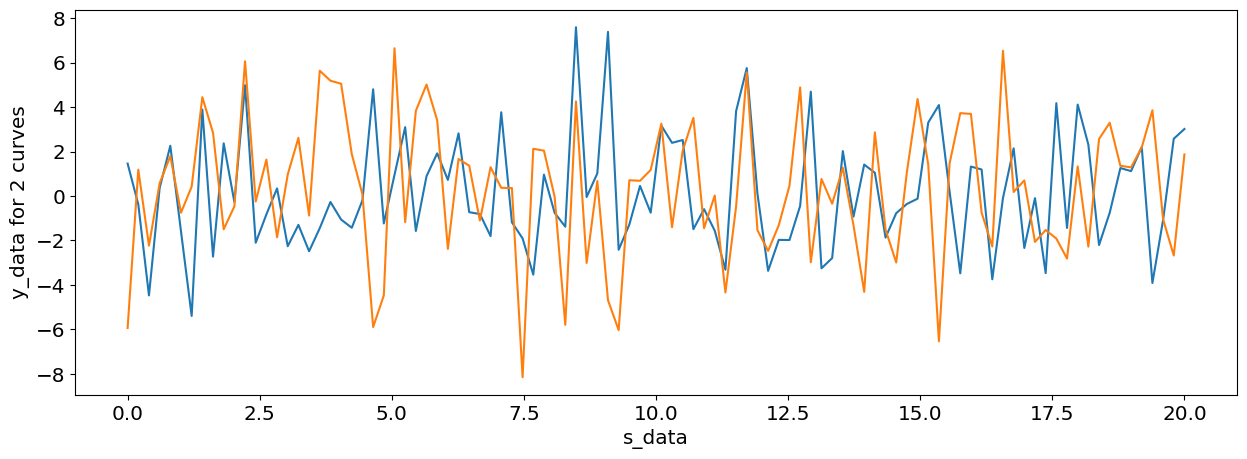

In [70]:
# simple plot
s_data = np.array(np.linspace(0,20,100)) # 100 points equally spaced between 0 and 20
y_data = 3*np.random.randn(100,2) # 100x2 random points
plt.plot(s_data, y_data)
plt.xlabel('s_data')
plt.ylabel('y_data for 2 curves')

Oone can profit of seaborn (`import seaborn as sns`) for more complex/nicer plots.

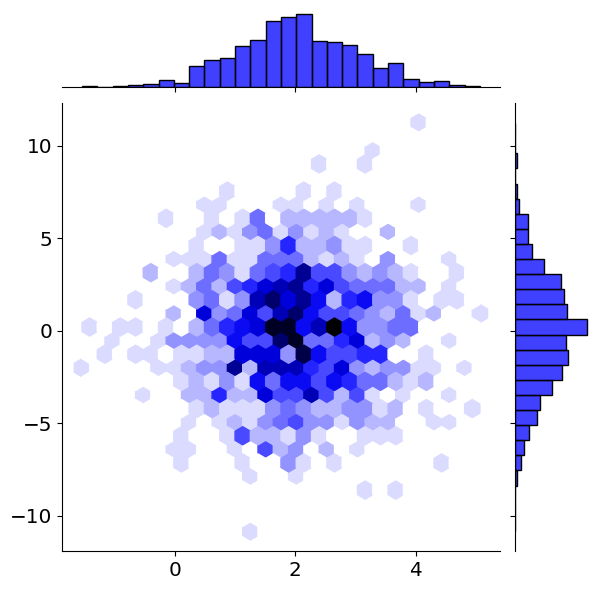

In [71]:
# something more fancy
x_data = np.random.randn(1000)+2
y_data = 3*np.random.randn(1000)
sns.jointplot(x=x_data, y=y_data, kind="hex", color="b")

#### Something more fancy: animations (optional)

one can profit of the "interactive" package (`from ipywidgets import interactive`)
for creating user-friendly interactive plots, e.g. while varying a parameter

In [72]:
# define x array
data_x = np.linspace(-1,1,100)

# define the function to be executed at each change of some input parameter
def plotIt(a, b, c):
    data_y = a*(plot_x)**3 + b*(plot_x)**2 + c*(plot_x)
    plt.plot(plot_x, data_y, 'o-b', lw=3)

# create interactive plot, and display it
interactive_plot = interactive(plotIt,a=(-1,1,.1),b=(-2,2,.1),c=(-3,3,.1),continuous_update=True)
aux = interactive_plot.children[-1]
aux.layout.height = '150px'
display(interactive_plot)

interactive(children=(FloatSlider(value=0.0, description='a', max=1.0, min=-1.0), FloatSlider(value=0.0, descr…

---

## Essentials

---

## The Physics Basis

From [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/), you learnt about **matrices** and particle trajectories:

<p align="center">
<img src=./_img_exercises/upload_0c59b4d203ab8bd7b31827ad332baca1.png width="60%">
</p>

Those matrices are the **building blocks** for our  course. Please, keep them in mind.

#### Note about variables

- In this course, we will concentrate mainly on the **horizontal** (or vertical) dynamics. 
- The motion of **charged particles** with respect to the "center" of a beamline resamples the motion of **optical rays** in optical systems.
- If we were to be more formal, charged particles are best described by **Hamiltonian dynamics** using **canonical coordinates**. 
    - Typical **canonical coordinates** are the horizontal (or vertical) position $x$, and the corresponding horizontal momentum $p_x$ divided by the reference momentum $p_0$, i.e. $PX=p_x/p_0$.
    - If we assume that particle trajectories have **small offsets and angles** (say less than a few mm and mrad) with respect to the "axis" of long (say a few m-long) beamline under study, then:
    \begin{equation}
       PX = \frac{p_x}{p_0} \approx \frac{p_x}{p_s} = \tan(x') \approx x'
    \end{equation}
    where $p_s$ is the projected momentum along the beamline direction (i.e. coordinate $s$), and $x'$ is the angle of the particle with respect to the $s$.
    - Therefore, we assume here that using $(x, x')$ as **position-angle phase-space coordinates** is a **valid approximation**.

#### Note about units

- We will use units derived from the "Système International" (SI), e.g. lengths in metres and angles in radians. 
- However, our approximation is valid assuming small transverse positions and angles!
    - From [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/) the dynamics we are studying is linear:

        \begin{equation}
        \vec{x_s} = M \cdot \vec{x_0}
        \end{equation}
        
    - So we can multiply by $1000$ on both side and obtain:
    
        \begin{equation}
        \vec{x_s} (\text{in mm,mrad}) = 1000 \cdot \vec{x_s} (\text{in m,rad}) = 1000 \cdot M \cdot \vec{x_0} (\text{in m,rad}) =  M \cdot (1000 \cdot \vec{x_0} (\text{in m,rad})) = M \cdot \vec{x_0} (\text{in mm,mrad})
        \end{equation}
    
- We will therefore assume that **all matrices** will have units in **(m, rad)**, while all **particle coordinates** in **(mm, mrad)**.



---

# Model and tracking of a single particle

---

### Exercise 1 (guided)
A `drift` is represented by a matrix with ones on the diagonal and the length of the drift on the upper right corner:

\begin{equation}
D=\left[
\begin{array}{c}
1\quad L\\
0\quad 1
\end{array}
\right],
\end{equation}

Show, numerically, that matrix-multiplying two such matrices, one with $L_1 = 0.5$ m and the other with $L_2 = 0.2$ m in the upper right corner, produces a matrix with the sum of the distances in the upper right corner (i.e. $L_1+L_2 = 0.7$ m).

#### SOLUTION
Even if we can prove it by hand, we take the opportunity to start learning how to use Numpy arrays in Python...

In [228]:
# Let's set our lengths
L_1 = 0.5
L_2 = 0.2

# we define the matrices (Numpy arrays)
# NOTA BENE: when defining a numpy 2D array (i.e. a matrix) 
#            the innermost-array represent a row of our matrix
DRIFT_1 = np.array([[1, L_1], [0, 1]])
DRIFT_2 = np.array([[1, L_2], [0, 1]])

# let's see our matrices:
print(f'DRIFT 1:\n {DRIFT_1}')
print(f'DRIFT 2:\n {DRIFT_2}')

DRIFT 1:
 [[1.  0.5]
 [0.  1. ]]
DRIFT 2:
 [[1.  0.2]
 [0.  1. ]]


In [229]:
# let's multiply the matrices:
print(f'DRIFT 1+2:\n {DRIFT_1*DRIFT_2}')

DRIFT 1+2:
 [[1.  0.1]
 [0.  1. ]]


**QUESTION: what did we expect? is the solution provided by numpy correct?**

In [230]:
(DRIFT_1*DRIFT_2)[0,1] == L_1 + L_2

False

**BE CAREFUL!** the `*` operator produces **"element-by-element" multiplication**, but here we are looking for a **"matrix multiplication"** operation.
The **`@` operator** is the "multiplication between matrices", introduced in python 3, which you should be using instead.

In [231]:
# => the @ operator is the "multiplication between matrices"
print(f'(correct) DRIFT 1+2:\n {DRIFT_1@DRIFT_2}')
(DRIFT_1@DRIFT_2)[0,1] == L_1 + L_2

(correct) DRIFT 1+2:
 [[1.  0.7]
 [0.  1. ]]


True

**QUESTION: what is the difference between `DRIFT_2 @ DRIFT_1` and `DRIFT_1 @ DRIFT_2`? Is this important?**


Remember that the *final* coordinates of a particle, $\vec{x_s}$, are given as:

\begin{equation}
\vec{x_s} = M_n \cdot ... \cdot M_2 \cdot M_1 \cdot \vec{x_0}
\end{equation}

where $\vec{x_0}$ are the initial coordinates, $M_1$ is the first element/matrix encountered by the particle, followed by $M_2$ ... $M_n$.

### Exercise 2 (guided)

A single particle is described by a column vector containing its phase-space coordinates ($x$, $x'$):
\begin{equation}
\vec{x} = X = \left(
\begin{array}{c}
x \\
x'
\end{array}
\right).
\end{equation}

Describe a ray, or particle, that is on the optical axis with an angle $x' = 0.5$ mrad. 
Then, transport this particle to the end of a 2 m long drift using the matrix formalism. 

#### SOLUTION

Using numpy arrays, a column vector is represented by a 2D array with 2 rows and 1 column. 

If the particle is on the optical axis, then $x$ must be zero, while $p_x$ repres 

In [232]:
# in Python
x = 0 # initial position
xp = 0.5 # initial angle
X_0 = np.array([[x], [xp]])
print(f'Initial particle coordinates:\n {X_0}')

Initial particle coordinates:
 [[0. ]
 [0.5]]


In [233]:
# we build the drift as we did earlier on:
L = 2
DRIFT = np.array([[1, L], [0, 1]])

# and transport the initial particle to the end of the drift:
X_1 = DRIFT @ X_0
print(f'Final particle coordinates:\n {X_1}')

Final particle coordinates:
 [[1. ]
 [0.5]]


**Note:** Going through a drift of length $L$, the angle of the particle is not affected $x'_1 = x'_0$, while the final position is increased by $x_1 = x_0 + L * x'_0$

### Exercise 3

As for the drift, implement a focusing quadrupole matrix (using the thin lens approximation) with focal length $f = 2$.

Build the transfer matrix of a beam line made of such a quadrupole followed by a drift of length $L = f = 2$.

Transport one particle that starts with an initial offset (e.g. x_0 = 0.4 mm) through such a system. What is the final position (x_1)? Try to vary the initial offset: what do you see?

**Hint 1**: recall from [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/):

<p align="center">
<img src=./_img_exercises/upload_938d56be287cccab0bd618456f94efc1.png width="60%">
</p>

**Hint 2**: think a little extra about ordering of the matrices.

#### SOLUTION

In [234]:
# Let's define a quadrupole with focal length f1, as in Ex. 1
f = 2
QUAD = np.array([[1, 0], [-1/f, 1]])

# Let's define a drift of length L=f, as in Ex. 1
L = f
DRIFT = np.array([[1, L], [0, 1]])

# And our initial vector (parallel ray), as in Ex. 2
x = 0.4 # initial position
xp = 0 # initial angle
X_0 = np.array([[x], [xp]])

# And we propagate, as in Ex. 2
X_1 = DRIFT @ QUAD @ X_0
print(f'Final particle coordinates:\n {X_1}')
print(f'Final particle x:\n {X_1[0,0]} mm')


Final particle coordinates:
 [[ 0. ]
 [-0.2]]
Final particle x:
 0.0 mm


The particle arrives on the beam axis! We have built an imaging system!

### Exercise 4

The phase-space coordinates of several, say $N$, particles can be conveniently collected in a $2 \times N$ matrix:
\begin{equation}
X = \left[ 
    \left(
    \begin{array}{c}
    x \\
    x'
    \end{array}
    \right)_1
    \left(
    \begin{array}{c}
    x \\
    x'
    \end{array}
    \right)_2
    \left(
    \begin{array}{c}
    x \\
    x'
    \end{array}
    \right)_3
    \cdots
    \left(
    \begin{array}{c}
    x \\
    x'
    \end{array}
    \right)_N
\right]
\end{equation}

This is very convenient, as we can then transport all particles through the very same matrix multiplication: 
\begin{equation}
X_1 = M \cdot X_0
\end{equation}
where $X_0$ are the initial coordinates, and $X_1$ the final ones. 

Using this formalism, describe $N=5$ particles all with initial angle $xp_0=0$, but different initial $x_0$, e.g. [-2,-1,0,1,2] mm.

Then, track all particles along the imaging system of the previous exercise, and once more prove that all particles cross the beam axis, eventually using a simple plot.

What happens if you modify your beam line such that $f \ne L$?


In [170]:
# Same as previous exercise, create the necessary transport matrices:
f = 2
QUAD = np.array([[1, 0], [-1/f, 1]])
L = f
DRIFT = np.array([[1, L], [0, 1]])

In [171]:
# Let's define all initial conditions in a matrix:
X_0 = np.array([[-2,-1,0,1,2], [0,0,0,0,0]])

In [235]:
# Finally, we propagate our coordinates along our system
X_1 = DRIFT @ QUAD @ X_0
print(f'Final particle coordinates:\n {X_1}')
print(f'Final particle xs:\n {X_1[0,:]} mm')

Final particle coordinates:
 [[ 0. ]
 [-0.2]]
Final particle xs:
 [0.] mm


Text(0, 0.5, 'Final x_1 [mm]')

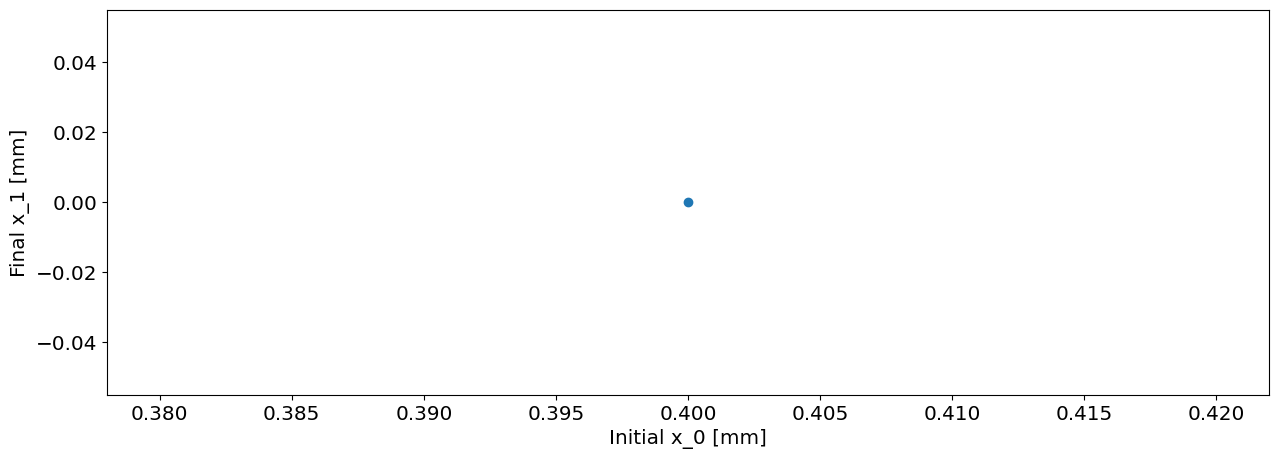

In [236]:
# We can plot, for example, the final x as a function of the initial one for each particle:
plt.plot(X_0[0,:], X_1[0,:], 'o-')
plt.xlabel('Initial x_0 [mm]')
plt.ylabel('Final x_1 [mm]')

We see that no matter the inital offset, the particle is always on the beam axis. **This is the meaning of the focal length!** 

What happens if we go away from the $f=L$ condition?

Text(0, 0.5, 'Final x_1')

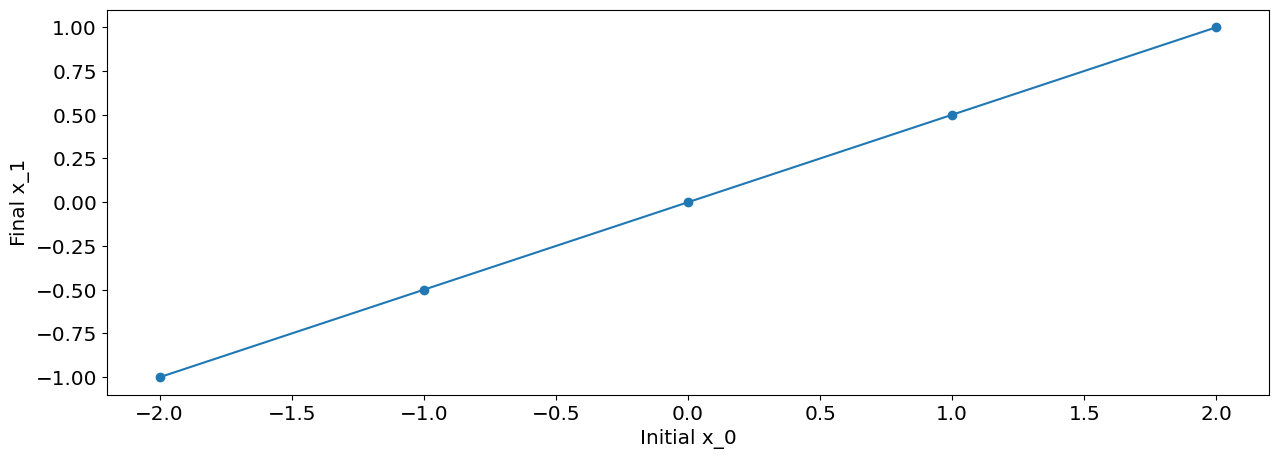

In [174]:
# Let's build a new system:
f = 2
QUAD = np.array([[1, 0], [-1/f, 1]])
L = 1
DRIFT = np.array([[1, L], [0, 1]])
# let's use the same initial coordinates:
X_0 = np.array([[-2,-1,0,1,2], [0,0,0,0,0]])
# track and plot:
X_1 = DRIFT @ QUAD @ X_0
plt.plot(X_0[0,:], X_1[0,:], 'o-')
plt.xlabel('Initial x_0 [mm]')
plt.ylabel('Final x_1 [mm]')

Clearly, the final x coordinate is not zero anymore (except for the particle with $x_0 = 0$), however, the behavior of the system remains linear.

---

# Interlude: a small tracking library

---


## Some more convenient functions to model an accelerator

We are going to define some important functions, very useful for the rest of the exercises.

### Modeling of a drift

Let's start with a function that generate a convenient representation of a **drift**. 

In [180]:
def D(L):
    '''Returns a list containing a drift of length L'''
    # NB: we return a list with a dict
    # the dict contains the matrix (the transformation)
    # and the element length 
    return [{'matrix':np.array([[1, L],[0, 1]]), 'length':L}] 

# A drift of L=2 m can be generated as:
D(2)

[{'matrix': array([[1, 2],
         [0, 1]]),
  'length': 2}]

The main reason for returning such a `list` with inside a `dictionary` are:

- it will allow us to keep track of the path travelled by the particle (thanks to the `length` dictionary key)
- the element is embedded in a list so to allow for an easy concatenation of elements (e.g. D(1.2) + D(4.3) will produce a list with two elements: one representing a drift of L=1.2 and one of L=4.3 m).

You can find more details about this choice on our ["*Transverse Linear Beam Dynamics Primer using Python*"](./CAS_Optics_Primer.pdf)

In [182]:
# e.g. representation of a beamline made of two drifts of different length:
D(1) + D(2)

[{'matrix': array([[1, 1],
         [0, 1]]),
  'length': 1},
 {'matrix': array([[1, 2],
         [0, 1]]),
  'length': 2}]

> **Note:** this is just **one of many possible implementation** choices.
> One could think of different structures and ways to model a beamline.
> The scope of this course is not to give you a high-efficency and optimised tracking code, 
> but to **help you to understand** the basics of the underlying **accelerator physics**.

### Modeling of a quadrupole

In [183]:
def Q(f):
    '''Returns a list containing a quadrupole with focal length f'''
    # NB: we return a list with a dict
    # the dict contains the matrix (the transformation)
    # and the element length 
    return [{'matrix':np.array([[1, 0],[-1/f, 1]]), 'length':0}]

# e.g. representation of a beamline made of one drift followed by one quadrupole:
D(1) + Q(2)

[{'matrix': array([[1, 1],
         [0, 1]]),
  'length': 1},
 {'matrix': array([[ 1. ,  0. ],
         [-0.5,  1. ]]),
  'length': 0}]

### From a list of elements - or beamline - to an equivalent single element

A beam line (or a whole ring) is modelled by a series of matrices. Independently of the initial particle coordinates, we can compute a single matrix ($M_{eq.}$) that represents the whole beam line (or ring): 

\begin{equation}
X_s = M_n \cdot ... \cdot M_2 \cdot M_1 \cdot X_0 = M_{eq.} \cdot X_0
\end{equation}

Given our choice of beamline strcuture, i.e. a `list` of **elements**, each modeled by a `dictionary` with some properties, we can define a useful function to compute the *equivalent* matrix $M_{eq.}$ (actually an *equivalent* **element** represented by a `dictionary` inside a `list`) of a whole beamline made of several **elements**:

In [184]:
def getEquivalentElement(beamline):
    '''Returns the single element which is equivalent of the given beamline'''
    # we start from an identity matrix (np.eye)
    # with the same dimension of the matrix of the
    # first element of the beamline
    equivalentElement = np.eye(beamline[0]['matrix'].shape[0])
    length = 0
    # NB: we reverse the order of the beamline ([-1::-1])
    for elements in beamline[-1::-1]:
        # we multiply the matrices 
        equivalentElement = equivalentElement @ elements['matrix']
        # and we add the lengths
        length = length + elements['length']
    # we return the dict with the "usual" keys (matrix and length) embedded in a
    #  list (with a single element), as for the definition of the D and Q functions
    return [{'matrix':equivalentElement, 'length':length}]

# e.g. equivalent representation of a beamline made of two drifts of different length:
getEquivalentElement(D(1) + D(2))

[{'matrix': array([[1., 3.],
         [0., 1.]]),
  'length': 3}]

### Tracking particles along a beamline

We can also write a function that "tracks" one, or several particles defined by their initial coordinate, along a beamline. 
The `transportParticles` function will create a list of particle coordinates for each location along the beam line, as well as a list of s positions.

In [268]:
def transportParticles(X_0, beamline, s_0=0):
    '''Track the particle(s) `X_0` along the given `beamline`. 
    If needed, one can specify an initial longitudinal position `s_0`, otherwise set to 0.

    It will return a dictionary containing the following key:values
       'x': a NxM numpy array with the M-particles x position for all N-elements of the beamline
       'xp': a NxM numpy array with the M-particles x' angles for all N-elements of the beamline
       's': a N-long numpy array with the longitudinal position of the N-elements of the beamline
       'coords': a Nx2xM numpy array with all M-particles coordinates (both x and x') at all N-elements of the beamline
    
    Disclaimer: if beamline is made of 5 elements, the output will have 5+1 "elements" as it will also 
                return include the initial particle coordinates.
    '''
    coords = [X_0]
    s = [s_0]
    for element in beamline:
        coords.append(element['matrix'] @ coords[-1])
        s.append(s[-1] + element['length']) 
    coords = np.array(coords)
    s = np.array(s)
    return {'x':  coords[:,0,:], # [s_idx, particle_idx]
            'xp': coords[:,1,:], # [s_idx, particle_idx]
            's':  s,   # [s_idx]
            'coords': coords,}   # [s_idx, coord_idx, particle_idx]

Text(0, 0.5, 'x [mm]')

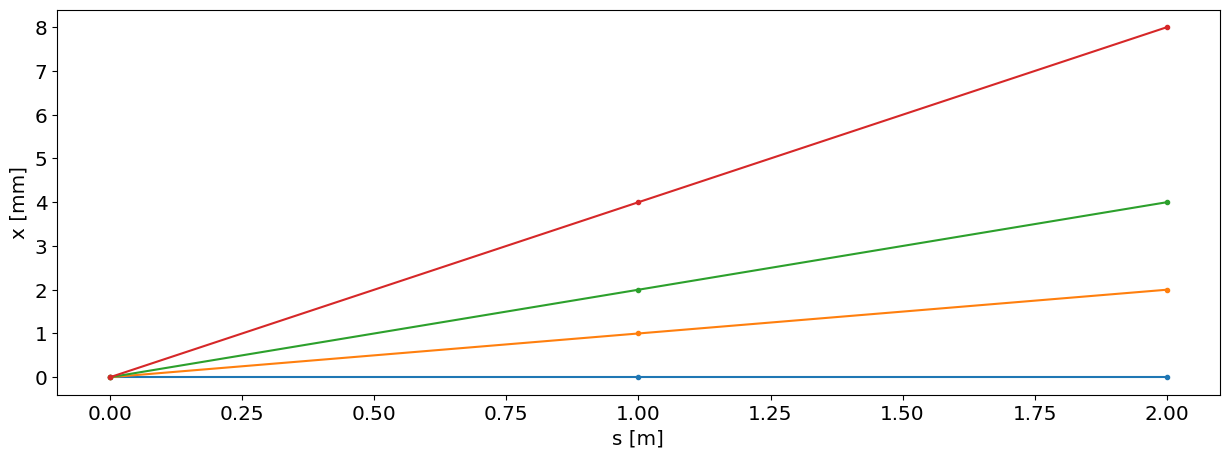

In [242]:
# e.g. define the intial coordinates for 3 particles all with
#      0 x position, but different angles:
X_0 = [[0,0,0,0],
       [0,1,2,4]]
# and let's transport them through a lattice made of 2 equally long drifts
tracked_data = transportParticles(X_0, D(1)+D(1))
# and plot the trajectories of all particles, i.e. x as a function of s:
plt.plot(tracked_data['s'], tracked_data['x'], '.-')
plt.xlabel('s [m]')
plt.ylabel('x [mm]')


### Exercise 5
Let's consider the beamline from [Exercise 4](#exercise-4), i.e. a quadrupole followed by a drift such that $f=L=2.5$, however model the drift as a series of $L/10$ long drifts.

Verify once more that parallel rays (e.g. $x_0$ = [-2,-1,0,1,2] mm) cross the axis after a distance $L=f$, but this time **using our newly developed functions**:
- Plot the final position of all particles (profiting of `getEquivalentElement`)
- Plot the trajectory of all rays/particles along the beamline (profiting of `transportParticles`).

#### SOLUTION 1 - using `getEquivalentElement` function.

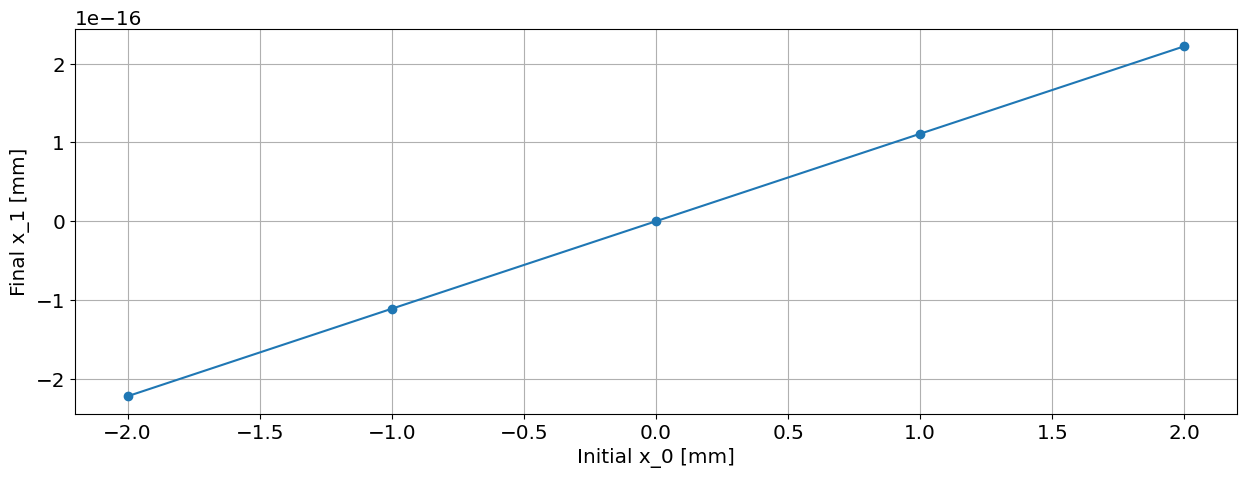

In [243]:
# Particles definition:
X_0 = np.array([[-2,-1,0,1,2], [0,0,0,0,0]])
# beamline definition:
f = 2 # [m]
beamline = Q(f) + 10 * D(f/10)
# compute equivalent element
equivalent_element = getEquivalentElement(beamline)
# extract the first(only) matrix, and multiply it by the initial particle coordinates:
X_1 = equivalent_element[0]['matrix'] @ X_0

# plotting (careful with exponents on the y-axis)
plt.plot(X_0[0,:], X_1[0,:], 'o-')
plt.xlabel('Initial x_0 [mm]')
plt.ylabel('Final x_1 [mm]')
plt.grid(True)

#### SOLUTION 2 - using `transportParticles` function.

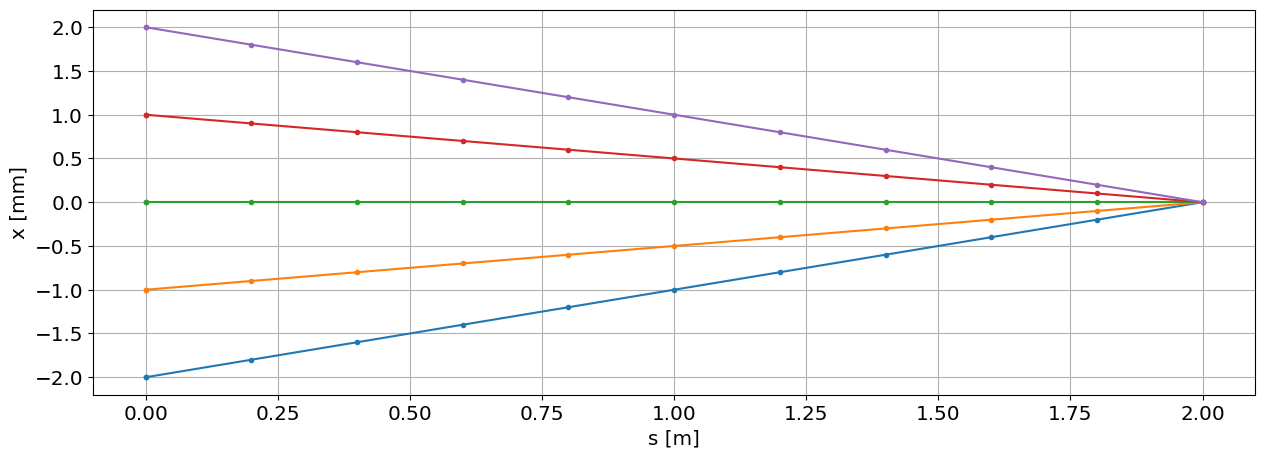

In [244]:
# we the transportParticles function we can se the particle along the line
# this can help to visualize the concept of focal length
transported_particles = transportParticles(X_0, beamline)
plt.plot(transported_particles['s'], transported_particles['x'],'.-')
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.grid(True)

Indeed we found back the expected results, except for some numerical errors... 

---

# Now is your turn!

Continue by yourself with the following exercises profiting of the library of functions just introduced...

---

### Exercise 6
Recall that the **imaging equation** for a lens is $1/b+1/g=1/f,$ which corresponds to a system of one focusing lens with focal length $f,$ sandwiched between drift spaces with lengths $b$ and $g$.

1. Write a beamline description that corresponds to this system, with, for example, $b=3$ m and $g=2$ m.
2. Prove that the particles starting with a random angle $x'_0$ and zero position $x$ are focused back to the end of such a system.
   
   **Hint:** you can create a random ensample of particles with such properties as `X = np.array([np.zeros(n_particles),np.random.randn(n_particles)])` where `n_particles` is the numbers of particles you want to generate.

3. (Optional) Try to change the position of the quadrupole, i.e. $b$, while keeping fixed the total length of the imaging system (i.e. $b+g=5$ m). Plot both position and angle trajectory for one particle with $x=0$ and $x'_0=1$ mrad for different values of $b$, and show that, with an approriate change of $f$, this particle is always focused back to $x=0$ at the end of system, but what happens to the angle?

   **Hint:** for this exercise it is useful to make a small animation with the `interactive` package. 

#### SOLUTION 1

In [245]:
# our parameters and beamline description
b = 3
g = 2
f = 1/(1/b+1/g)
beamline = D(b) + Q(f) + D(g)

#### SOLUTION 2

Text(0, 0.5, 'x [mm]')

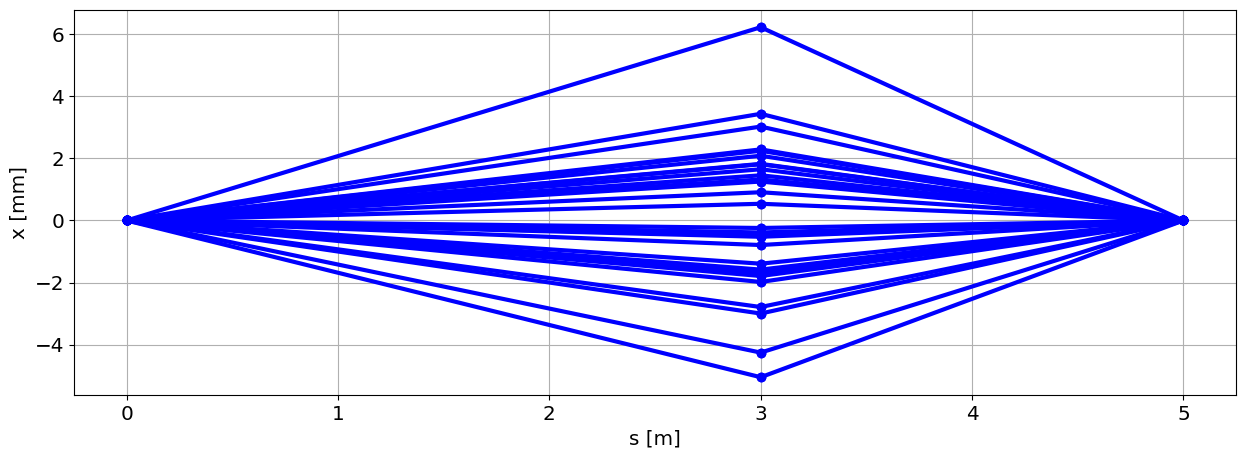

In [246]:
# define several particles with a random angle and zero position
n_particles = 30
X = np.array([np.zeros(n_particles),np.random.randn(n_particles)])
# track the particles and plot the output
transported_particles = transportParticles(X, beamline)

plt.plot(transported_particles['s'], transported_particles['x'], 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('x [mm]')

#### SOLUTION 3 (optional/guided)
We can do a small animation showing that, moving the position of the quadruple and keeping fulfilled the imaging equation the particle entering with x=0 will exit with x=0.

We will see that the closer will be the quadrupole to the end of the system, the larger will be the angle.

In [248]:
# we define the function to be-executed at every change of `b`:
def plotIt(b):
    L = 5
    g = L-b
    f = 1/(1/b+1/g)
    beamline = D(b) + Q(f) + D(g)

    X = np.array([[0],[1]])
    transported_particles = transportParticles(X, beamline)

    plt.plot(transported_particles['s'], transported_particles['x'], 'o-b', lw=3)
    plt.grid(True)
    plt.xlabel('s [m]')
    plt.ylabel('x [mm]', color='b')
    plt.tick_params(axis='y', labelcolor='b')
    plt.ylim([-1,4.5])

    # Note: After having plotted $x$ trajectory on a plot, one can create a second vertical axis that shares the same horizontal axis with `plt.twinx()`
    ax2 = plt.twinx()  
    plt.ylabel("x' [mrad]", color='r')
    plt.tick_params(axis='y', labelcolor='r')
    plt.plot(transported_particles['s'], transported_particles['xp'], 's-r', lw=3)
    plt.ylim([-5,5])

# create the interactive plot with a range of `b` parameter
interactive_plot = interactive(plotIt,b=(0.1,4.9,.1),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '350px'
display(interactive_plot)

interactive(children=(FloatSlider(value=2.5000000000000004, description='b', max=4.9, min=0.1), Output(layout=…

### Exercise 7

Define a **FODO beamline** that starts in the middle of a drift. 
Then, model a particle that is on the optical axis, but has an initial angle $x' = 1$ mrad and plot the position $x$ along the beam line.

**Hint:** A FODO cell is one of the most fundamental lattice topologies. Look back at [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/). 
For the moment we can define arbitrarily the $f$ and $L$ parameters: we chose 2.5 m and 1 m, respectively. 
As in [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/), we define $L$ as the length of one drift, i.e. the total length of the cell ($L_{FODO}$) is $2L$. 

<p align="center">
<img src=./_img_exercises/slide_fodo.png width="60%">
</p>

**Hint:** To better visualize the trajectory of the particle(s), always split the drifts in several shorter drifts (e.g. $10$ drifts, each $L/10$ long).

#### SOLUTION 
The first part of the exercise is to define a FODO cell structure.  In its simpler version, it consists on two thin quadrupoles of opposite focal length, f, spaced by two drifts of length L (2*L is the total length of the cell). We can start the FODO from an arbitrary point inside it. We decided to start describing it from the center of a drift.

In [249]:
f = 2.5
L = 1
beamline = 5*D(L/10)+Q(f)+10*D(L/(10))+Q(-f)+5*D(L/10)

Please pay attention that in order to sample more finely the particle trajectory in the drift we split them in pieces of 0.1 m.

We can now proceed to generate a particle and transport it along the beamline:

Text(0.5, 1.0, 'Exercise 7')

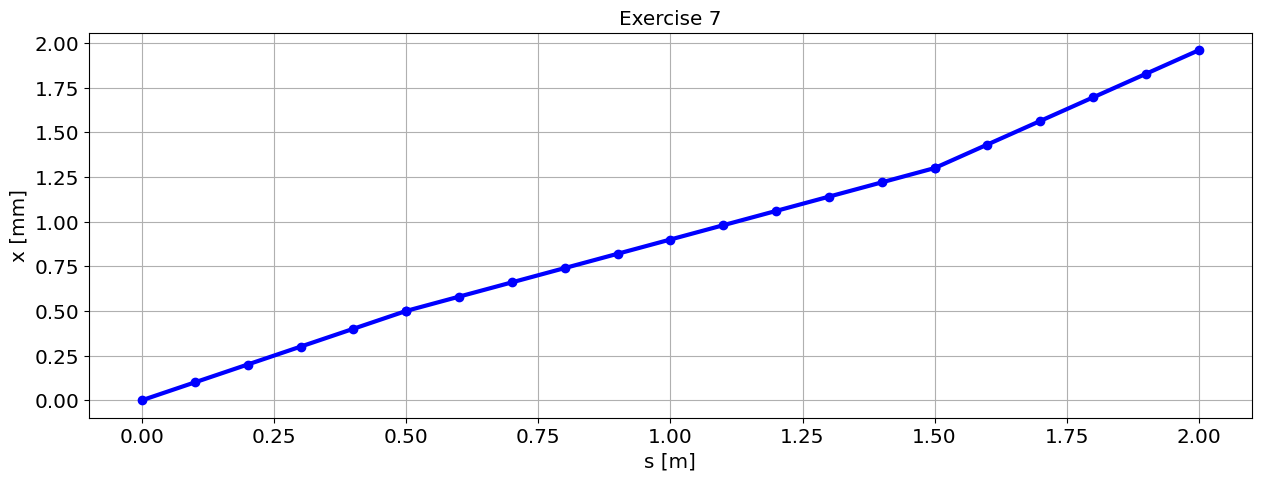

In [250]:
X = np.array([[0],[1]])

transported_particles = transportParticles(X, beamline)
plt.plot(transported_particles['s'], transported_particles['x'], 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.title('Exercise 7')

### Exercise 8
Plot the angle $x'$ along the beam line.

#### SOLUTION

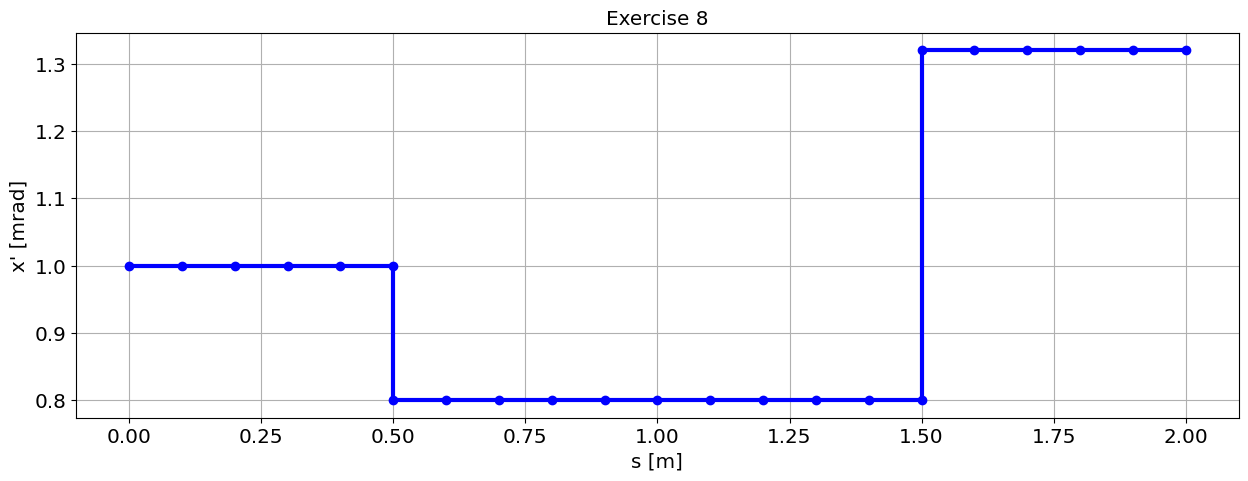

In [22]:
plt.plot(transported_particles['s'], transported_particles['xp'], 'r-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel("x' [mrad]")
plt.title('Exercise 8')

### Exercise 9

Plot both the position $x$ and the angle $x'$ through five cells.

**Hint:** After having plotted $x$ trajectory on a plot, one can create a second vertical axis that shares the same horizontal axis with `plt.twinx()`


#### SOLUTION

Text(0.5, 1.0, 'Exercise 9')

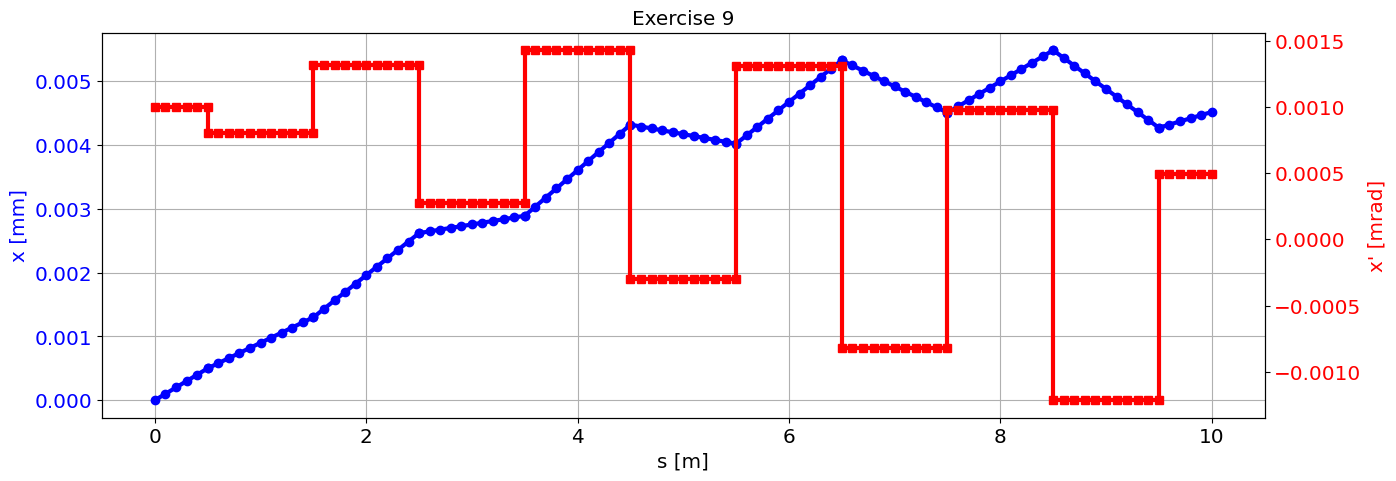

In [251]:
X = np.array([[0],[0.001]])

# the transport over 5 cell can be achieved simply by multiplying the beamline description by 5
transported_particles = transportParticles(X, 5*beamline)
    
plt.plot(transported_particles['s'], transported_particles['x'], 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('x [mm]', color='b')
plt.tick_params(axis='y', labelcolor='b')

# instantiate a second axes that shares the same x-axis, and color it in red
plt.twinx()  
plt.ylabel("x' [mrad]", color='r')
plt.tick_params(axis='y', labelcolor='r')
# plot the angle as well:
plt.plot(transported_particles['s'], transported_particles['xp'], 's-r', lw=3)
plt.title('Exercise 9')

### Exercise 10

Plot the position $x$ and angle $x'$ through 100 cells, play with different values of the focal length $f$ and explore whether you can make the oscillations grow.

**Hint:** Look back at [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/):

<p align="center">
<img src=./_img_exercises/slide_stability.png width="60%">
</p>

#### SOLUTION

Text(0.5, 1.0, 'Exercise 10')

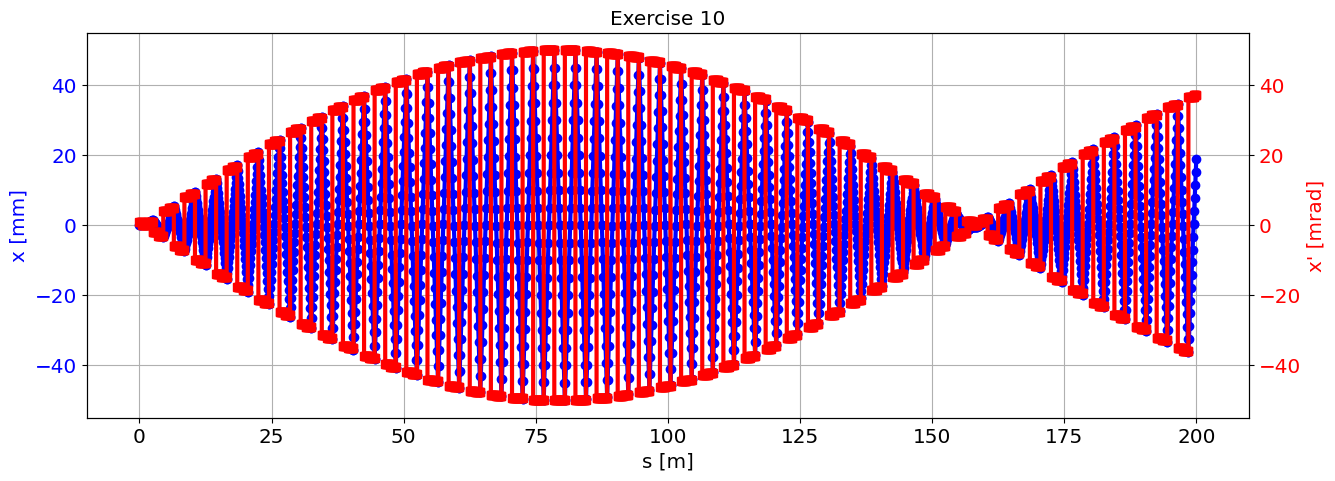

In [85]:
f = .5001
L = 1
beamline = 5*D(L/10)+Q(f)+10*D(L/(10))+Q(-f)+5*D(L/10)


X = np.array([[0],[0.001]])
transported_particles = transportParticles(X, 100*beamline)

plt.plot(transported_particles['s'], transported_particles['x'], 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('x [mm]', color='b')
plt.tick_params(axis='y', labelcolor='b')

# instantiate a second axes that shares the same x-axis
ax2 = plt.twinx()
plt.ylabel("x' [mrad]", color='r')
plt.tick_params(axis='y', labelcolor='r')
plt.plot(transported_particles['s'], transported_particles['xp'], 's-r', lw=3)
plt.title('Exercise 10')

It it important to observe that when the focal length approaches the stability limit (only for $f>L_{FODO}/4$ the machine is stable), then the oscillation start to grow during the transport in the lattice.

---

## Moving beams around: from single particle to whole beam

---

### Exercise 12 (guided)

Define an ensemble of 1000 particles with an arbitrary first order ($x_0 = 0.2$ mm, $x'_0 = 1$ mrad) and second order momenta($\sigma_{x_0}$ and $\sigma_{x'_0}$).
Verify that the angular divergence of the beam is the one set: what do you observe? What happens if you increase or decrease the number of particles?

**Hint:** Remember that you can create a Normal distributed 2xN 2D array of numbers as `np.random.randn(2, N)`. One can then "stretch" and "offset" (and eventually "rotate", but this is not requested here) this distribution to obtain any desired 2D normal distribution in phase space.


#### SOLUTION

In [252]:
# simple solution
N_particles = 1000
beam = np.random.randn(2, N_particles)
x0 = 0.2
xp0 = 1
sigx = 1.5
sigxp = 0.5
beam[0,:] = sigx*beam[0,:]+x0
beam[1,:] = sigxp*beam[1,:]+xp0
print(f'Beam mean  x [mm]: {np.mean(beam[0,:])}')
print(f"Beam mean  x' [mrad]: {np.mean(beam[1,:])}")
print(f'Beam rms size [mm]: {np.std(beam[0,:])}')
print(f"Beam rms divergence [mrad]: {np.std(beam[1,:])}")

Beam mean  x [mm]: 0.2572864561293364
Beam mean  x' [mrad]: 1.0114008697556687
Beam rms size [mm]: 1.5709983045143296
Beam rms divergence [mrad]: 0.4953720598249045


**NOTE:** We did not find back the rms values and offsets that we initially set (e.g. 0.5 for $\sigma_{x'_0}$) due to the statistical error coming with the finite numbers of particles. We can explore the dependence of the statistical error with on the beam divergence by a numerical simulation.

Text(0.5, 1.0, 'Exercise 12')

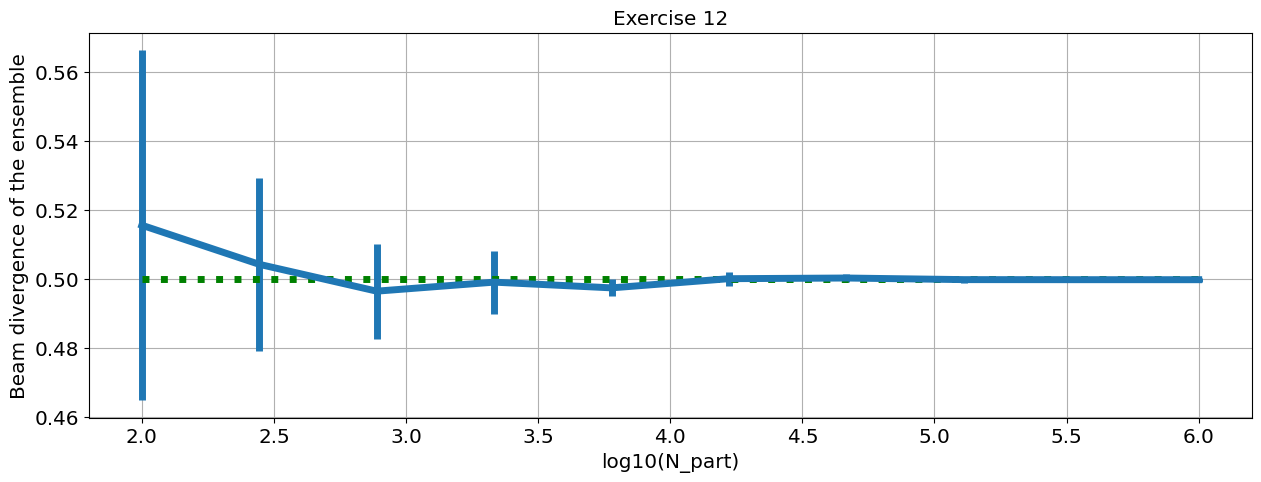

In [253]:
myDivergence = []
myDivergenceStatisticalError = []
Npart_range = np.round(np.logspace(2,6,10))
Npart_range = Npart_range.astype(int)
for Npart in Npart_range:
    aux = []
    for j in range(10):
        beam = np.random.randn(2, Npart)
        beam[0,:] = sigx*beam[0,:]+x0
        beam[1,:] = sigxp*beam[1,:]+xp0
        aux.append(np.std(beam[1,:]))
    myDivergence.append(np.mean(aux))
    myDivergenceStatisticalError.append(np.std(aux))
plt.errorbar(np.log10(Npart_range),myDivergence,myDivergenceStatisticalError,lw=5)
plt.plot([2,6],[sigxp,sigxp],':g',lw=5)
plt.grid(True)
plt.xlabel('log10(N_part)')
plt.ylabel('Beam divergence of the ensemble')
plt.title('Exercise 12')

> **Depending on the required precision we need to select a convenient number of particles!**

### Exercise 13

1. Transport the beam distribution of [Exercise 12](#exercise-12-guided) in a drift of length 1 m. Visualise the initial and final distribution.

   **Hint:** One can use the `seaborn` package to nicely see a 2D distribution

2. Test of linearity.  Scale the input vector by 17 times the month of your birthday (e.g. 85 if you are born in May) and verify that the output vector from the matrix multiplication has changed by the same factor.
    
    **Hint:** Be careful with machine precision!

3. Consider 3 particles (e.g. the first 3 of your ensample) such that they define a triangle of surface A. Verify that this linear transport preserve the area of the triangle.

    **Hint:** the area of a triangle in phase space can be computed using linear algebra:
    ```
    from numpy.linalg import norm
    def area(a, b, c) :
        '''a,b,c are the phase-space coordinates of three particles'''
        return 0.5 * norm( np.cross( b-a, c-a ) )
    ```

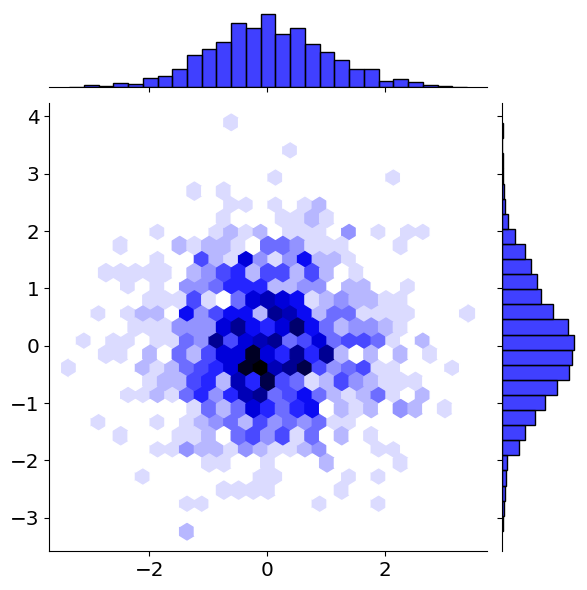

In [254]:
import seaborn as sns
sns.jointplot(x=np.random.randn(1000), y=np.random.randn(1000), kind="hex", color="b")

#### SOLUTION - transport

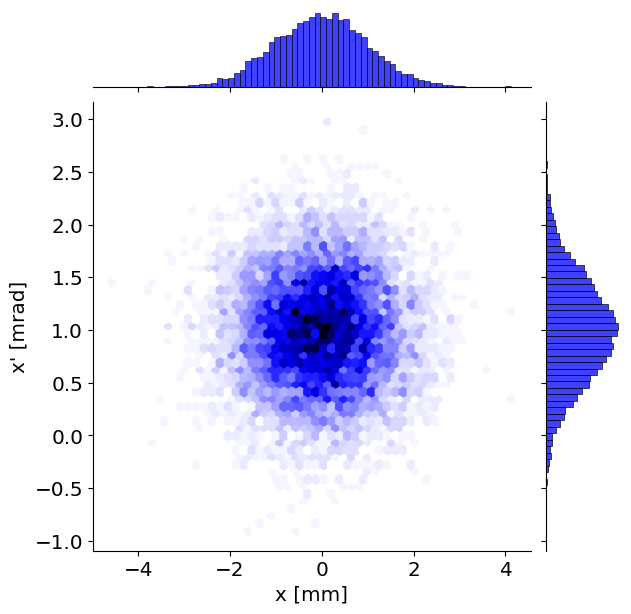

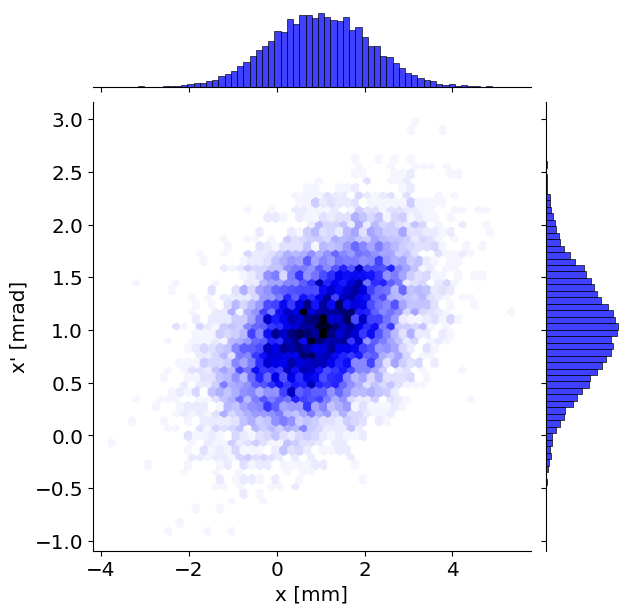

In [255]:
Npart = 10000
beam = np.random.randn(2, Npart)
x0 = 0
xp0 = 1
sigx = 1
sigxp = 0.5
beam[0,:] = sigx*beam[0,:]+x0
beam[1,:] = sigxp*beam[1,:]+xp0

beam_after_drift = D(1)[0]['matrix'] @ np.array(beam)

# Before the drift
g = sns.jointplot(x=beam[0,:], y=beam[1,:], kind="hex", color="b")
g.set_axis_labels("x [mm]", "x' [mrad]")
#g.savefig('before_drift.pdf')
# After the drift
g = sns.jointplot(x=beam_after_drift[0,:], y=beam_after_drift[1,:],
                  kind="hex", color="b")
g.set_axis_labels("x [mm]", "x' [mrad]")
#g.savefig('after_drift.pdf')

#### SOLUTION - test of linearity

In [256]:
# test of linearity
month_birthday = 3
v1 = D(1)[0]['matrix']@(17*month_birthday*beam)
v2 = 17*month_birthday*D(1)[0]['matrix']@(beam)

# this might return False due to machine precision rounding - See **Computational tools** course!:
print(np.array_equal(v1,v2))
# let's compare at the level of 10 times epsilon, times the scaling factor used for the test
print(np.max(np.abs(v1-v2)) < 10*17*month_birthday*np.finfo(v1.dtype).eps)

False
True


#### SOLUTION - area preservation

Now let us consider three points of the distributions and let us verify that the area of the triangle before and after the transoformation is preserved.
**IMPORTANT**: the area preservation is a condition stronger than the linearity. It is possible only for special matrices, the so-called symplectic matrices.
A $2\times2$ matrix is symplectic if and only if its determinant is one.

In [257]:
# this is the formula of the area of a triangle
from numpy.linalg import norm
def area(a, b, c) :
    '''a,b,c are the phase-space coordinates of three particles'''
    return 0.5 * norm( np.cross( b-a, c-a ) )

In [258]:
# we take the first three particles in the beam (arbitrary choise)
print(f"Before transport {area(beam[:,0],beam[:,1],beam[:,2])}")
print(f"After transport {area(beam_after_drift[:,0],beam_after_drift[:,1],beam_after_drift[:,2])}")

Before transport 0.04315623478227032
After transport 0.04315623478227035


We can visualise this in a plot:

Text(0.5, 1.0, 'Exercise 13')

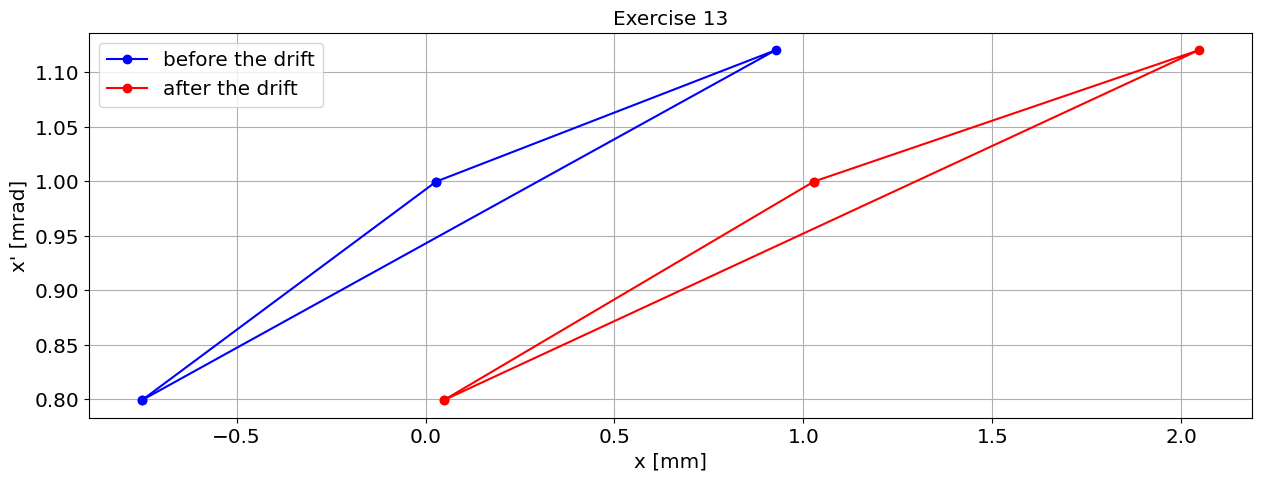

In [259]:
#first triangle
plt.plot(beam[:,:3][0],beam[:,:3][1],'o-b')
plt.plot(beam[:,[2,0]][0],beam[:,[2,0]][1],'o-b', label='before the drift')

#second triangle
plt.plot(beam_after_drift[:,:3][0],beam_after_drift[:,:3][1],'o-r')
plt.plot(beam_after_drift[:,[2,0]][0],beam_after_drift[:,[2,0]][1],'o-r',label='after the drift')

plt.legend()
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")
plt.grid(True)
plt.title('Exercise 13')

### Exercise 14
Using the 5 FODO cells of [Exercise 9](#exercise-9), transport the beam of [Exercise 13](#exercise-13) and plot the beam $size$ ($\sigma_x$) and $divergence$ ($\sigma_{x'}$) along the beam line.

**Hint:** Remember that in the output of our `transportParticles` function the key `'x'` contains a 2D array with N rows (the index of the position along the beam line) and M columns (the index of a given particle). 
Moreover, you can compute the standard deviation of **each raw** of a NxM 2D array as `np.std(N_times_M_array,1)`. 

#### SOLUTION

Text(0.5, 1.0, 'Exercise 14')

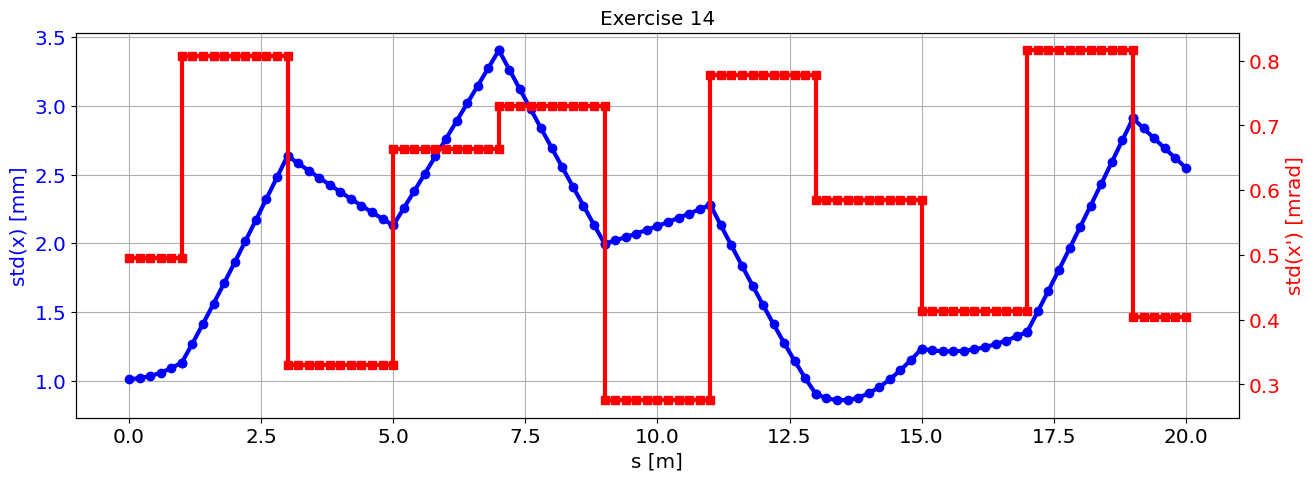

In [270]:
#prepare the optics
f = 2.5
L_2 = 2
fodo_lattice = 5*D(L_2/10)+Q(-f)+10*D(L_2/10)+Q(f)+5*D(L_2/10)

#prepare the beam
Npart = 10000
beam = np.random.randn(2, Npart)
x0 = 0
xp0 = 1
sigx = 1
sigxp = 0.5
beam[0,:] = sigx*beam[0,:]+x0
beam[1,:] = sigxp*beam[1,:]+xp0

transported_particles = transportParticles(beam, 5*fodo_lattice)

plt.plot(transported_particles['s'], np.std(transported_particles['x'],1), 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('std(x) [mm]', color='b')
plt.tick_params(axis='y', labelcolor='b')

ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis
plt.ylabel("std(x') [mrad]", color='r')
plt.tick_params(axis='y', labelcolor='r')
plt.plot(transported_particles['s'], np.std(transported_particles['xp'],1), 's-r', lw=3)
#plt.savefig('exercise14.pdf')
plt.title('Exercise 14')

---

### Interlude: track of sigma matrices

---

Recall Equation 7 of our [Primer](./CAS_Optics_Primer.pdf):

\begin{equation}
\vec X(s_2) =  R\, \vec X(s_1)
\qquad\mathrm{and}\qquad
\sigma(s_2) = R\, \sigma(s_1)\, R^t\, .
\end{equation}

The same matrix used for tracking a single matrix can be used to track the covariance matrix ($\sigma$) as well as the mean ($\vec X$) of a given distribution.

We can therefore track the **average trajectory** of a beam simply starting from its initial average coordinates in phase space.

We can also write a simple function that tracks the sigma matrix along a beamline:

In [273]:
def transportSigmas(sigma_0, beamline):
    '''Transport the input sigma matrix (sigma_0) along the given beamline
    
    It will return a dictionary containing the following key:values
        'sigma11': a N-long numpy array with the \sigma_{11} value for all N-elements of the beamline
        'sigma12': a N-long numpy array with the \sigma_{12} value for all N-elements of the beamline
        'sigma21': a N-long numpy array with the \sigma_{21} value for all N-elements of the beamline
        'sigma22': a N-long numpy array with the \sigma_{22} value for all N-elements of the beamline
        's': a N-long numpy array with the longitudinal position of the N-elements of the beamline
        'sigmas': a Nx2x2 numpy array with all sigma matrices at all N-elements of the beamline
    
    Disclaimer: if beamline is made of 5 elements, the output will have 5+1 "elements" as it will also 
                return include the initial sigma matrix.
    '''

    sigmas = [sigma_0]
    s = [0]
    for element in beamline:
        sigmas.append(element['matrix'] @ sigmas[-1] @ element['matrix'].transpose())
        s.append(s[-1] + element['length']) 
    sigmas = np.array(sigmas)
    s = np.array(s)
    return {'sigma11': sigmas[:, 0, 0],
            'sigma12': sigmas[:, 0, 1],
            'sigma21': sigmas[:, 1, 0], # equal to sigma12
            'sigma22': sigmas[:, 1, 1],
            's':  s,
            'sigmas': sigmas,}

---

### Let's put this in practice

---

### Exercise 15

Show that the average position of a beam made of 100 particles along a beam line (e.g. our usual beamline made of 5 FODO cells) is the same as the the trajectory of single particle particle that starts in the center of the initial particle distribution.

#### SOLUTIONS

Text(0.5, 1.0, 'Exercise 15')

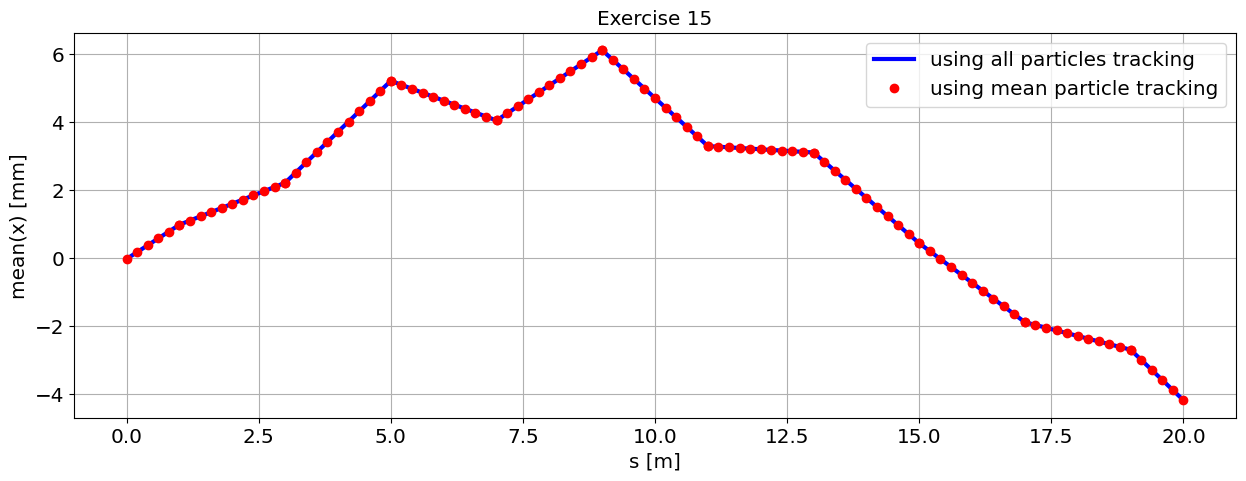

In [288]:
#lattice
f = 2.5
L_2 = 2
fodo_lattice= 5*D(L_2/10) + Q(f) + 10*D(L_2/10) + Q(-f) + 5*D(L_2/10)

#prepare the beam
Npart = 1000
beam0 = np.random.randn(2, Npart)
x0 = 0
xp0 = 1
sigx = 1 
sigxp = 0.2
beam0[0,:] = sigx*beam0[0,:] + x0
beam0[1,:] = sigxp*beam0[1,:] + xp0

# transport all particles 
transported_particles = transportParticles(beam0, 5*fodo_lattice)
# transport only the average position
mean_particle = np.array([[np.mean(beam0[0,:])], [np.mean(beam0[1,:])]])
transported_mean = transportParticles(mean_particle, 5*fodo_lattice)

plt.plot(transported_particles['s'], np.mean(transported_particles['x'],1), '-b', lw=3, label='using all particles tracking')
plt.plot(transported_mean['s'], transported_mean['x'], 'or', lw=3, label='using mean particle tracking')
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('mean(x) [mm]')
plt.legend()

# For saving the figure
#plt.savefig('exercise_15.pdf')
plt.title('Exercise 15')

### Excercise 16

For the same system as before, compare the rms beam size computed from tracking all particles and from using the sigma matrix approach.

**Note:** Is this valid for any number of initially tracked particles? How does the result change if one uses the **input** covariance matrix used to generate the particle distribution rather then the **actual** covariance matrix of the generated distribution?

**Hint 1:** Remember that the element $\sigma_{xx}$ of the covariance matrix is linked to the rms beam size ($\sigma_x$) as $\sigma_x = \sqrt{\sigma_{xx}}$.

**Hint 2:** The covariance matrix of a 2xN array can be computed using `numpy` as `np.cov(2_times_N_array, bias=True)`.

#### SOLUTION

Text(0.5, 1.0, 'Exercise 16')

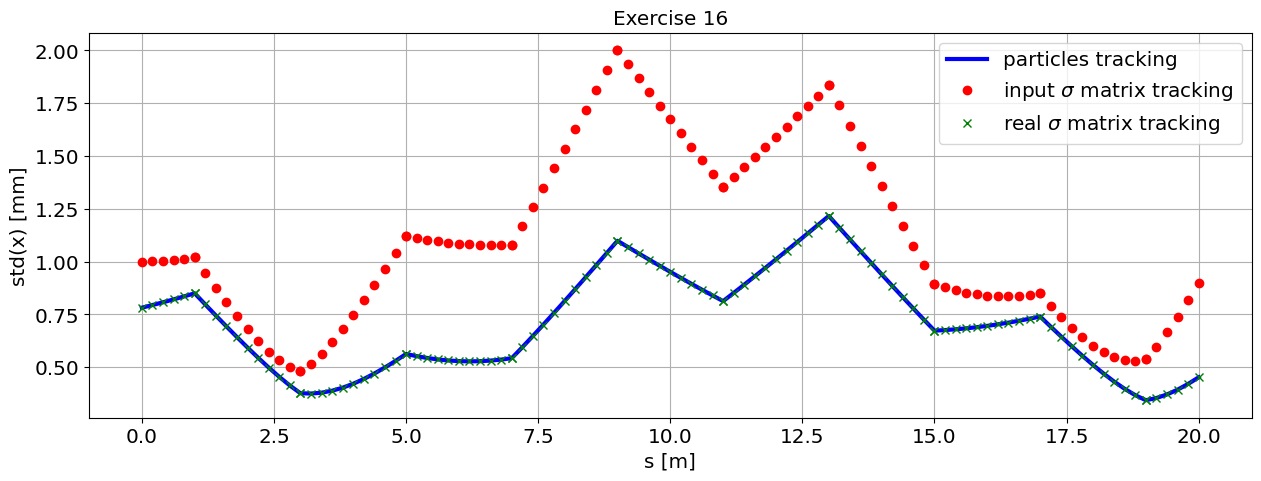

In [307]:
#lattice
f = 2.5
L_2 = 2
fodo_lattice= 5*D(L_2/10) + Q(f) + 10*D(L_2/10) + Q(-f) + 5*D(L_2/10)

#prepare the beam
Npart = 10
beam0 = np.random.randn(2, Npart)
x0 = 0
xp0 = 1
sigx = 1 
sigxp = 0.2
beam0[0,:] = sigx*beam0[0,:] + x0
beam0[1,:] = sigxp*beam0[1,:] + xp0

#prepare the sigma matrix based on our inputs:
sigma_0 = np.array([[sigx**2, 0], [0, sigxp**2]])
# alternative: if we use the covariance matrix of the generated distribution:
sigma_real = np.cov(beam0, bias=True)

# transport all particles:
transported_particles = transportParticles(beam0, 5*fodo_lattice)
# transport the sigma matrix only:
transported_sigmas = transportSigmas(sigma_0, 5*fodo_lattice)
transported_real_sigmas = transportSigmas(sigma_real, 5*fodo_lattice)

# plot all estimation of beam size:
plt.plot(transported_particles['s'],   np.std(transported_particles['x'],1), '-b', lw=3, label='particles tracking')
plt.plot(transported_sigmas['s'],      np.sqrt(transported_sigmas['sigma11']), 'or', lw=3, label='input $\sigma$ matrix tracking')
plt.plot(transported_real_sigmas['s'], np.sqrt(transported_real_sigmas['sigma11']), 'xg', lw=3, label='real $\sigma$ matrix tracking')
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('std(x) [mm]')
plt.legend()

# For saving the figure
#plt.savefig('exercise_16.pdf')
plt.title('Exercise 16')

It is important to observe that the result of from the particle tracking and the sigma matrix tracking are equivalent.
The small deviation is due to the statistical noise of the ensemble (it can be reduced by increasing the number of particles).
This deviation is zero (or numerical) if one tracks the actual covariance matrix of the ensemble of the generated particles. (Note that the `bias=True` option to numpy `cov` function is necessary to force the simple (bias) computation of the covariance)

Clearly the sigma matrix tracking is computationally cheaper than the particle tracking (if Npart>>1).

---
## The introduction of Twiss values and emittance
---

The sigma/covariance matrix of any particle distribution can also be written as:

\begin{equation}
\sigma = 
    \left[
    \begin{array}{cc}
    \sigma_{xx}  & \sigma_{xx'}\\
    \sigma_{x'x} & \sigma_{x'x'}
    \end{array}
    \right] =
    \epsilon
    \left[ 
    \begin{array}{cc}
        \beta   & -\alpha\\
        -\alpha & \gamma
    \end{array}
    \right] 
\end{equation}

where $\beta$, $\alpha$, $\gamma$ and $\epsilon$ are parameters such that $\epsilon = \sqrt{\det(\sigma)}$ and $\beta \gamma - \alpha^2 = 1$. 

**For the time being, this seems to be an arbitrary choice!** but it will acquire more special meaning later.

In the meantime, recall once more that:

\begin{equation}
\sigma(s_2) = R\, \sigma(s_1)\, R^t\, .
\end{equation}

where $R$ is a real **symplectic** transformation, and its determinant is $\det(R) = +1$, therefore:

\begin{equation}
\epsilon_2 = \det(\sigma(s_2)) = \det( R\, \sigma(s_1)\, R^t ) = \det(R) \det(\sigma(s_1)) \det(R^t) = \det(\sigma(s_1)) = \sigma_1
\end{equation}

Which means that the quantity $\epsilon$ (the beam **statistical emittance**) is **preserved** along a beamline!

### Exercise 25
Verify that the equivalent transport matrix of any beamline, e.g. our usual FODO cell, has determinant equal to 1.

**Hint:** you can use `np.linalg.det(my_matrix)` to compute the determinant of a matrix `my_matrix`

#### SOLUTION

In [311]:
f = 2.5
L_2 = 2
fodo_lattice= 5*D(L_2/10) + Q(f) + 10*D(L_2/10) + Q(-f) + 5*D(L_2/10)
OTM = getEquivalentElement(fodo_lattice)
print(f'The determinant of the FODO OTM is {np.linalg.det(OTM[0]["matrix"])}.')

The determinant of the OTM is 1.0000000000000002.


### Exercise 26

Consider our usual FODO cell, and create a valid sigma matrix with:
- $\beta$ = 3 [m]
- $\gamma$ = 0.5 [1/m]
- $\epsilon$ = 5 [$\mu$ m]

Then, propagate the $\sigma$ matrix through the beam line and verify that the emittance $\epsilon$ of the sigma matrix after every element is indeed constant and equal to its initial value.

**Optional:** compute and plot the **beta** function all along the beamline. 

**Hint:** in the output of our `transportSigmas()` function we keep all sigma matrixes. The determinant of all matrices can be computed in one go as `np.linalg.det(transported_sigmas['sigmas'])`.

#### SOLUTION

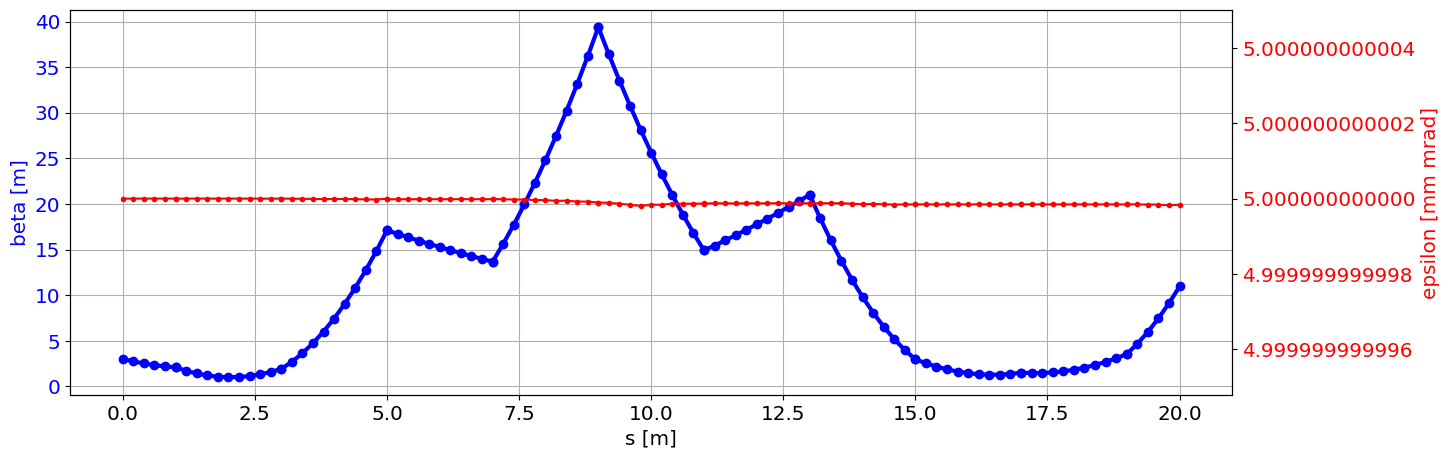

In [328]:
#lattice
f = 2.5
L_2 = 2
fodo_lattice= 5*D(L_2/10) + Q(f) + 10*D(L_2/10) + Q(-f) + 5*D(L_2/10)

# let's create a simple sigma matrix
beta0 = 3
gamma0 = 0.5
epsilon0 = 5
# alfa must be:
alfa0 = np.sqrt(beta0*gamma0 - 1)
sigma_0 = epsilon0 * np.array([[beta0, -alfa0], [-alfa0, gamma0]])

# transport the sigma matrix:
transported_sigmas = transportSigmas(sigma_0, 5*fodo_lattice)

# compute the emittance as sqrt of the determinant of all sigma matrices along 
# the beamline
emittance = np.sqrt(np.linalg.det(transported_sigmas['sigmas']))
# the beta function can be extracted as well from the 'sigma11' element, 
# divided by the emittance
beta = transported_sigmas['sigma11']/emittance

# make a simple plot
plt.plot(transported_sigmas['s'], beta, 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('beta [m]', color='b')
plt.tick_params(axis='y', labelcolor='b')

ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis
plt.ylabel("epsilon [mm mrad]", color='r')
plt.tick_params(axis='y', labelcolor='r')
plt.plot(transported_sigmas['s'], emittance,'.-r')
plt.ticklabel_format(useOffset=False)


---

## Periodic solutions

---

### Exercise 17
Try to find an initial beam matrix sigma0 by **try and error** that reproduces itself at the end of the beam line (5 FODO cells). You will quickly realise that this is extremely difficult if not impossible. 

**Hint**: don't waist to much time with **try and error** approaches, but move on to the next exercise.

#### SOLUTION

This problem is not so simple. One could proceed with try and error. But there are three parameters to fix so it can be quite cumbersome... We can still try with an animated plot.

In [347]:
# A first version:

#lattice
f = 2.5
L = 2
fodo_lattice = 5*D(L/10) + Q(f) + 10*D(L/10) + Q(-f) + 5*D(L/10)

def plotIt(sigma11, sigma22, sigma12):
    #prepare the sigma matrix
    sigma0 = np.array([[sigma11, sigma12 ],[sigma12, sigma22]])

    output_b = transportSigmas(sigma0, 5*fodo_lattice)
    plt.figure(figsize=(15,6))
    plt.subplot(311)
    plt.plot(output_b['s'], output_b['sigma11'], '-b', lw=3)
    plt.ylabel('sigma11')
    plt.grid(True)
    plt.subplot(312)
    plt.plot(output_b['s'], output_b['sigma22'], '-r', lw=3)
    plt.ylabel('sigma22')
    plt.grid(True)
    plt.subplot(313)    
    plt.plot(output_b['s'], output_b['sigma12'], '-k', lw=3)
    plt.ylabel('sigma12')
    plt.grid(True)
    
interactive_plot = interactive(plotIt,sigma11=(10,20,.1),sigma22=(0,4,.1),sigma12=(-5,5,.1),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=15.0, description='sigma11', max=20.0, min=10.0), FloatSlider(value=2.…

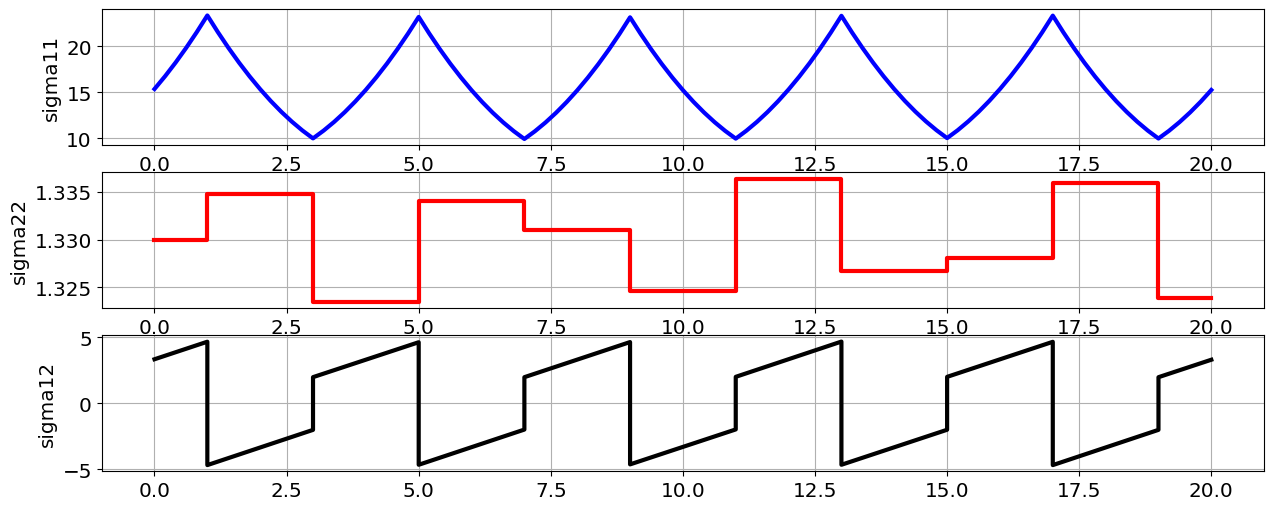

In [348]:
# **approximate** solution found by hand:
plotIt(15.37, 1.33, 3.34)

### Exercise 18 (was 21)

Try to simplify the problem of previous exercise. **Recall** [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/):

<p align="center">
<img src=./_img_exercises/slide_fodo_periodic.png width="60%">
</p>

In a FODO cell the $\beta$ function reaches a maximum (or a minimum) in the middle of the quadrupoles, i.e. the $\alpha$ function is zero.
If one models the FODO cell starting from the middle of a quadrupole (instead of the middle of a drift), then at least one parameter is fixed.

Even better: one can use the equation form [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/) to find the theoretical solution.

**Hint**: A half-quadrupole has double the focal length than a full quadrupole.

#### SOLUTION 1

We can then proceed again by try and error...

In [352]:
f = 2.5
L_2 = 2

# same structure, but starting the fodo cell from the center of a quadrupole:
fodo_lattice = Q(2*f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/10) + Q(2*f)

def plotIt(sigma11, sigma22):
    #prepare the sigma matrix
    sigma0 = np.array([[sigma11, 0 ],[0, sigma22]])

    output_b = transportSigmas(sigma0, 5*fodo_lattice)
    plt.figure(figsize=(15,6))
    plt.subplot(311)
    plt.plot(output_b['s'], output_b['sigma11'], '-b', lw=3)
    plt.ylabel('sigma11')
    plt.grid(True)
    plt.subplot(312)
    plt.plot(output_b['s'], output_b['sigma22'], '-r', lw=3)
    plt.ylabel('sigma22')
    plt.grid(True)
    plt.subplot(313)    
    plt.plot(output_b['s'], output_b['sigma12'], '-k', lw=3)
    plt.ylabel('sigma12')
    plt.grid(True)

interactive_plot = interactive(plotIt,sigma11=(0,25,.1),sigma22=(0,4,.1),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=12.0, description='sigma11', max=25.0), FloatSlider(value=2.0, descrip…

#### SOLUTION 2

We can use the learned during [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/) for this particular configuration:

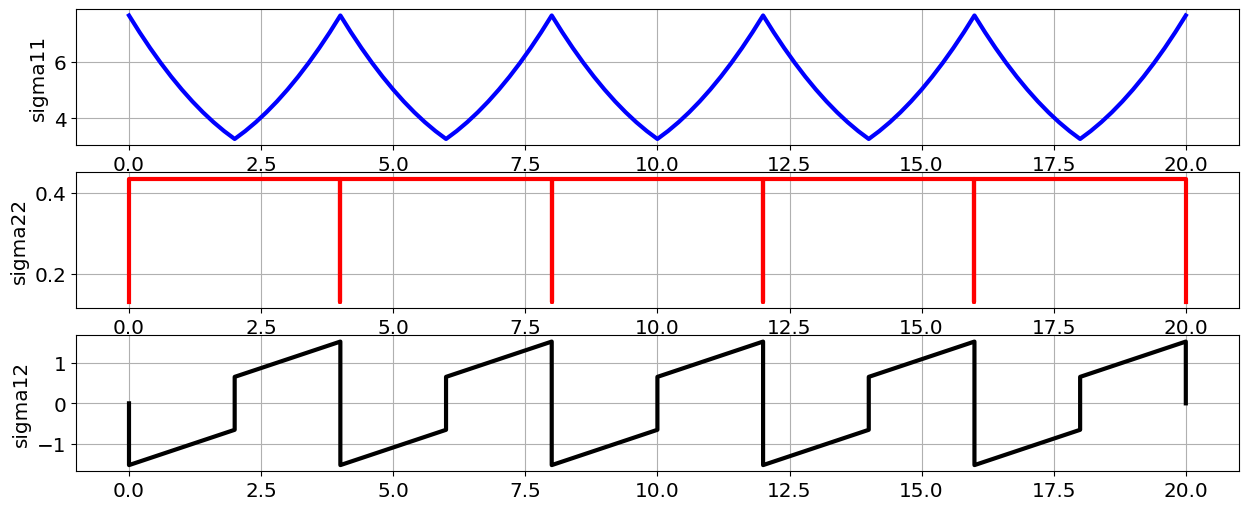

In [353]:
# get the one turn matrix:
fodo_lattice_reduced = getEquivalentElement(fodo_lattice)
# extract the matched initial conditions
sigma11 = fodo_lattice_reduced[0]['matrix'][0,1]/np.sqrt(1-(fodo_lattice_reduced[0]['matrix'][0,0])**2)
sigma22 = 1/sigma11
sigma12 = 0
# plot the solution (using function from previous exercise)
plotIt(sigma11, sigma22)

## General solution

**Recall** [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/). In a periodic beam line, the transfer matrix assumes the form:

\begin{equation}
R = 
    \left[
    \begin{array}{cc}
    \cos(\mu) + \alpha_0 \sin(\mu)  & \beta_0 \sin(\mu)\\
    - \gamma_0 \sin(\mu) & \cos(\mu) - \alpha_0 \sin(\mu)
    \end{array}
    \right]
\end{equation}

where $\alpha_0$, $\beta_0$, $\gamma_0$ are the initial (and final) Twiss values and $\mu$ is the phase advance (or tune, if we talk about a whole ring) of the associated beamline.
From this expression, one can extract the periodic solution of any beamline, assuming it exists!

Note: Since the determinant of $R$ must be one, then one can verify that the trace of the matrix R must be $|\mathrm{Tr}(R)| \le 2$ to ensure the existence of such a solution.

This can be implemented in a useful function:

In [354]:
def twiss(beamline):
    '''Returns the Q, and the Twiss parameters beta, alpha, gamma of the beamline'''
    OTM = getEquivalentElement(beamline)
    R = OTM[0]['matrix']
    mu = np.arccos(0.5*(R[0,0]+R[1,1]))
    if (R[0,1]<0): 
        mu = 2*np.pi-mu
    Q = mu/(2*np.pi)
    beta = R[0,1]/np.sin(mu)
    alpha = (0.5*(R[0,0]-R[1,1]))/np.sin(mu)
    gamma = (1+alpha**2)/beta
    return Q, beta, alpha, gamma

### Exercise 22

Let's go back to our initial FODO cell, starting from the middle of a drift.
Find the range of focal lengths $f$ for which the FODO cells permit stable oscillations based on the newly introduced condition (i.e. $|Tr(R)| \le 2$)

#### SOLUTION


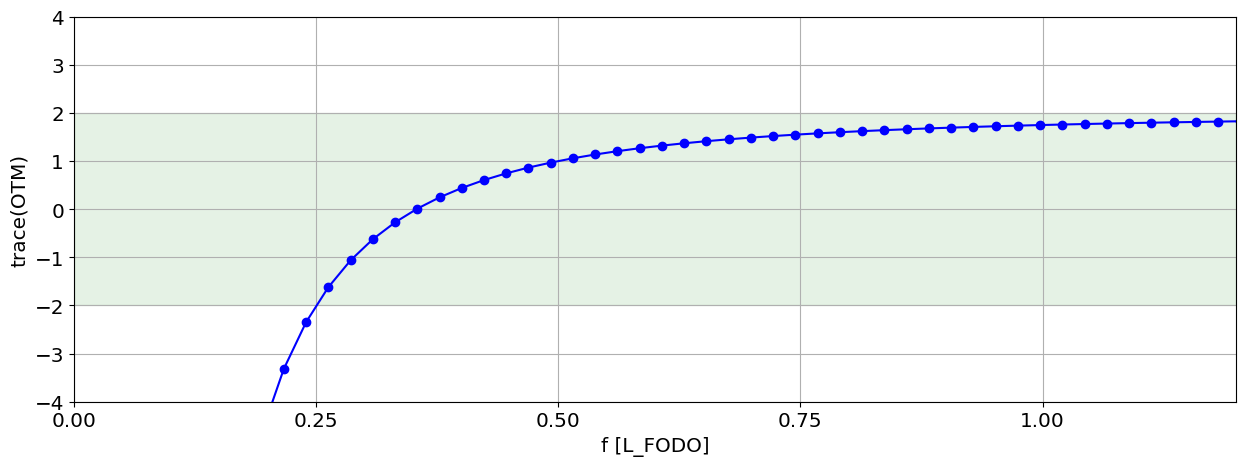

In [355]:
def myOTM_trace(L, f):
    fodo_lattice = 5*D(L/10) + Q(f) + 10*D(L/10) + Q(-f) + 5*D(L/10)
    OTM = getEquivalentElement(fodo_lattice)
    return np.trace(OTM[0]['matrix'])

def setShadedRegion(ax,color='g' ,xLimit=[0,1], yLimit='FullRange',alpha=.1):
    """
    setShadedRegion(ax,color='g' ,xLimit=[0,1],alpha=.1)
    ax: plot axis to use
    color: color of the shaded region
    xLimit: vector with two scalars, the start and the end point
    alpha: transparency settings
    yLimit: if set to "FullRange" shaded the entire plot in the y direction
    If you want to specify an intervall, please enter a two scalar vector as xLimit
    """
    if yLimit == 'FullRange':
        aux = ax.get_ylim()
        plt.gca().fill_between(xLimit, [aux[0],aux[0]],  [aux[1],aux[1]],color=color, alpha=alpha)
        ax.set_ylim(aux)
    else:
        plt.gca().fill_between(xLimit, 
                    [yLimit[0],yLimit[0]],  [yLimit[1],yLimit[1]],color=color, alpha=alpha)

L = 2  
f_range = np.linspace(.5,5)
plt.plot(f_range/(L*2), [myOTM_trace(L, f) for f in f_range],'-bo')
plt.xlim([0,1.2])
my_xlim = plt.xlim()
setShadedRegion(plt.gca(),xLimit=my_xlim,yLimit=[-2,2])
plt.ylim(-4,4)
plt.xlim(my_xlim);
plt.xticks([0, .25, .5, .75,1])
plt.xlabel('f [L_FODO]')
plt.ylabel('trace(OTM)')
plt.grid(True)

### Exercise 23

Consider our usual FODO cell starting from the middle of a drift, and which allows for having a periodic solution (i.e. $f > L_{FODO}/4$)
Compute the periodic $\sigma_0$ matrix using the Twiss parameters obtain for the newly defined `twiss` function (assuming $\epsilon=1$).

Transport the periodic $\sigma$ matrix along the FODO and convince yourself that the $\sigma$ matrix at the end of the FODO is indeed equal to the one at the start, $\sigma_0$.

#### SOLUTION

Text(0, 0.5, 'n.a.')

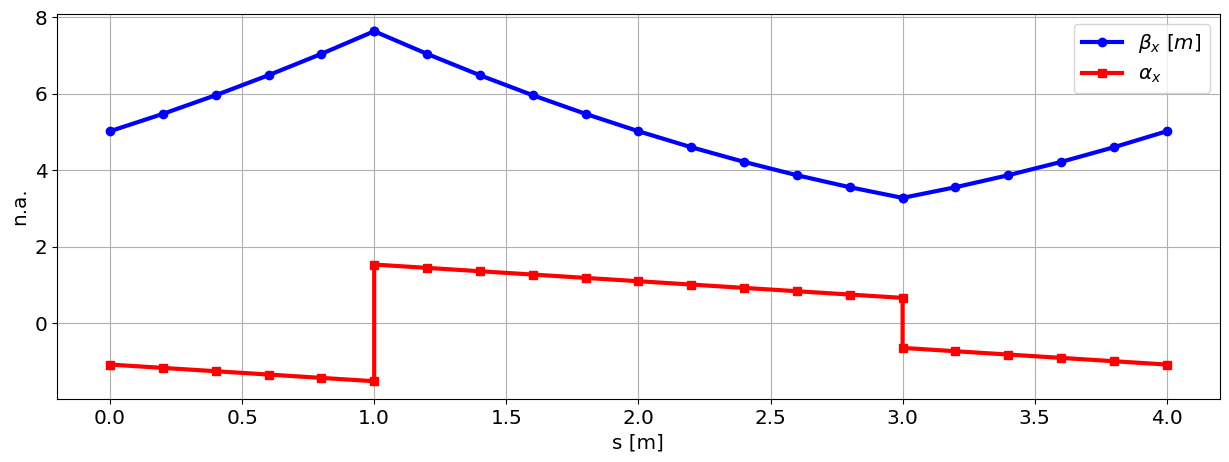

In [356]:
f = 2.5
L = 2
fodo_lattice = 5*D(L/10) + Q(f) + 10*D(L/10) + Q(-f) + 5*D(L/10)

# compute closed solution
tune, beta, alpha, gamma = twiss(fodo_lattice)
# build sigma matrix
sigma_0 = np.array([[beta, -alpha],[-alpha, gamma]])
# transport it
transported_sigmas = transportSigmas(sigma_0, fodo_lattice)

plt.plot(transported_sigmas['s'],  transported_sigmas['sigma11'], 'o-b', lw=3, label='$\\beta_x\ [m]$')
plt.plot(transported_sigmas['s'], -transported_sigmas['sigma12'], 's-r', lw=3, label='$\\alpha_x$')
    
plt.grid(True)
plt.legend(loc='best')
plt.xlabel('s [m]')
plt.ylabel('n.a.')

#plt.savefig('exercise_23.pdf')
#plt.title('Exercise 23')

### Exercise 24
Write down the numerical values of initial beam matrix $\sigma_0$, then build a beam line made of $15$ consecutive cells by changing the definition of the lattice and then, using $\sigma_0$ with the noted-down numbers, prepare a plot of the beam sizes along the $15$ cells. Is it also periodic?

#### SOLUTION

Text(0.5, 0, 's [m]')

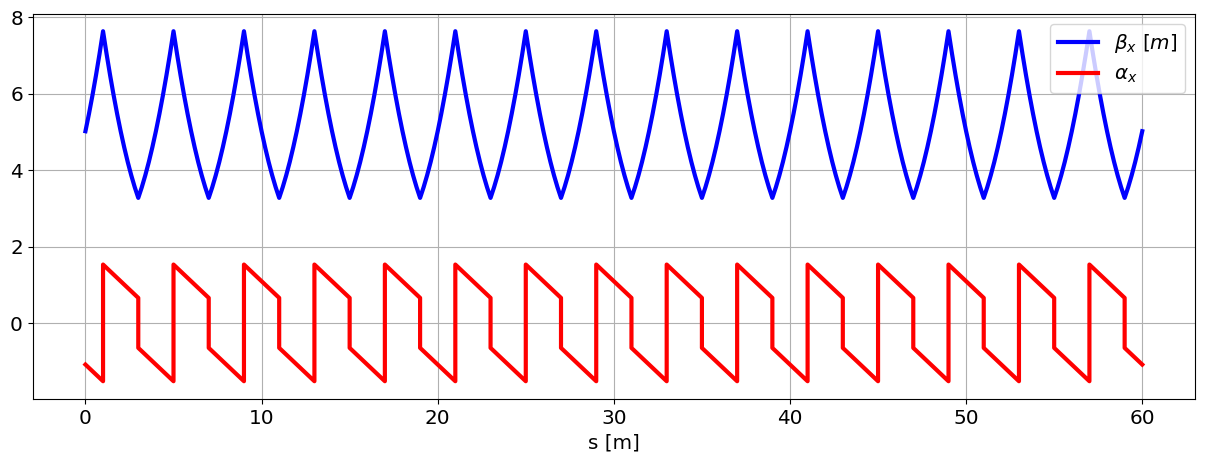

In [357]:
# as before:
f = 2.5
L = 2
fodo_lattice = 5*D(L/10) + Q(f) + 10*D(L/10) + Q(-f) + 5*D(L/10)
tune, beta, alpha, gamma = twiss(fodo_lattice)
sigma_0 = np.array([[beta, -alpha],[-alpha, gamma]])

# transport the solution found on a single cell over 15 cells
transported_sigmas = transportSigmas(sigma_0, 15*fodo_lattice)

plt.plot(transported_sigmas['s'],  transported_sigmas['sigma11'], '-b', lw=3, label='$\\beta_x\ [m]$')
plt.plot(transported_sigmas['s'], -transported_sigmas['sigma12'], '-r', lw=3, label='$\\alpha_x$')
plt.grid(True)
plt.legend(loc='best')
plt.xlabel('s [m]')

### Exercise 18

Consider our usual FODO cell.
Consider a single particle with some non-zero initial $x_0$ and/or $x_0'$, and plot the $x$, $x'$ coordinates at the end of each FODO cell for a beamline made of 100 cells. 

**Hint:** You should use both `getEquivalentElement` to obtain the single FODO cell element, and `transportParticles` function to track the particle over several of such a cell.

**Hint:** use `plt.scatter(output['x'], output['px']` to plot all phase-space coordinates.

#### SOLUTIONS
For plotting the trace space evolution of a particle we need to observe it turn-after-turn. The natural way to do that is to compress the beam line (in general composed by more than one element) in a single transformation: the one-turn-matrix, which can be computed using the `getEquivalentElement` function previously introduced.

In [358]:
f = 2.5
L = 2
fodo_lattice = 5*D(L/10) + Q(f) + 10*D(L/10) + Q(-f) + 5*D(L/10)
OTM = getEquivalentElement(fodo_lattice)
def plotIt(x, xp):
    particle = [[x],[xp]]
    transported_particles = transportParticles(particle,100*OTM)
    plt.scatter(transported_particles['x'], transported_particles['xp'], c = transported_particles['s']/(L*2))
    cb=plt.colorbar()
    cb.set_label('Turns')
    plt.xlabel('x [mm]')
    plt.ylabel("x' [mrad]")
    plt.xlim(-13,13)
    plt.ylim(-5,5)
    plt.grid(True)
    

interactive_plot = interactive(plotIt,x=(-2,2,.1),xp=(-2,2,.1),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='x', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

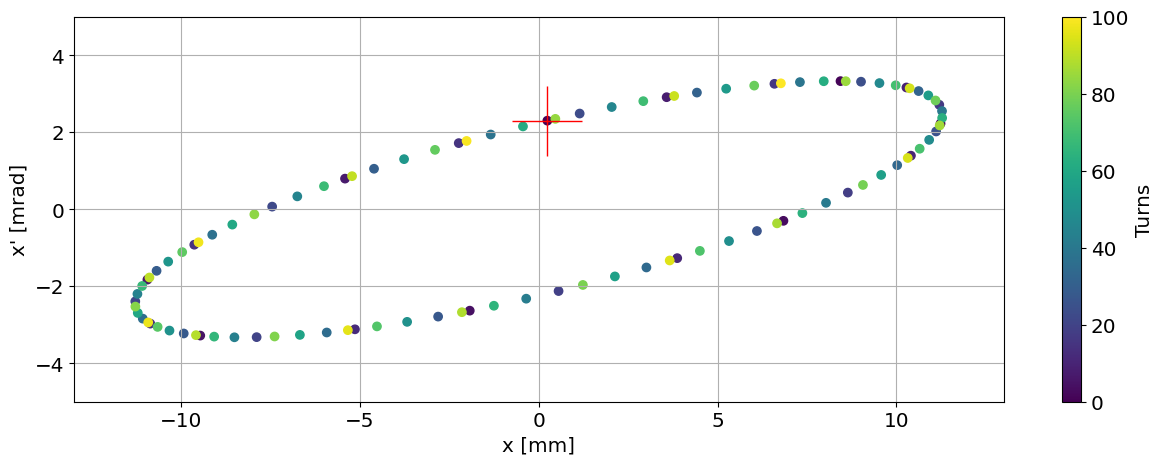

In [359]:
#  An example of static plot for saving...
x =.24
px = 2.3
plotIt(x, px)
plt.plot(x, px,'+r', ms=50)
#plt.savefig('exercise_18.pdf')

### Exercise 20 (optional)
In the definition of FODO of the previous exercise, reverse the polarity of both quadrupoles and prepare a phase-space plot. How does it differ from the one in Exercise 18?

#### SOLUTION

In [360]:
f = -2.5
L = 2
fodo_lattice = 5*D(L/10) + Q(f) + 10*D(L/10) + Q(-f) + 5*D(L/10)
OTM = getEquivalentElement(fodo_lattice)
def plotIt(x, xp):
    particle = [[x],[xp]]
    transported_particles = transportParticles(particle,100*OTM)
    plt.scatter(transported_particles['x'], transported_particles['xp'], c = transported_particles['s']/(L*2))
    cb=plt.colorbar()
    cb.set_label('Turns')
    plt.xlabel('x [mm]')
    plt.ylabel("x' [mrad]")
    plt.xlim(-13,13)
    plt.ylim(-5,5)
    plt.grid(True)

interactive_plot = interactive(plotIt,x=(-2,2,.1),xp=(-2,2,.1),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='x', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

---

## Ellipses

It turns out that our particle turn-after-turn stays on an ellipses: 

\begin{equation}
\epsilon = \gamma x^2 + 2 \alpha x x' + \beta x'\,^2
\end{equation}

where $(\alpha, \beta, \gamma)$ are the periodic Twiss parameter! and $\epsilon$, in this case, is the **single particle emittance**.

Without entering in the implementation details, let's define two useful functions that can give us the single particle emittance (`particle_emittance(x, xp, beta, alpha)`) or to give us the coordinate in phase space for an ellipse with the given Twiss and emittance (`ellipse_points(emittance, beta, alpha, n_points = 100)`)

In [370]:
def particle_emittance(x, xp, beta, alpha):
    '''Returns the single particle emittance for a given 
       x, xp particle coordinates and assumed beta and alpha parameters
    '''
    # compute gamma
    gamma = (alpha**2 + 1)/beta
    # compute and return the associated single particle emittance
    epsilon = gamma*x**2 + 2*alpha*x*xp + beta*xp**2
    return epsilon

def ellipse_points(emittance, beta, alpha, n_points = 100):
    ''' Returns the x,x' coordinates of an ellipse in phase space for 
        the given Twiss parameters (beta, gamma, emittance)
    '''
    # generate a uniform sampling of phases:
    thetas = np.linspace(0, 2*np.pi, n_points)
    # generate coordinates
    x  = np.sqrt(emittance*beta)*np.cos(thetas)
    xp = -np.sqrt(emittance/beta)*(alpha*np.cos(thetas)-np.sin(thetas))
    # return them in our usual form
    return np.array([x, xp])


### Exercise XXX

Consider the usual FODO cell, repeated 100 times.
Plot the trajectory, in phase space, of a particle with x=1 mm and xp=0 cell after cell.

Using the functions you have now available, compute the expected periodic solution of our cell, and use this information to:

- compute the single particle emittance
- produce the coordinates in phase space of an ellipse with such an emittance

Plot both the tracked particle coordinates and the ellipse in phase space: what do you observe?

**Optional:** would you be able to predict the exact tracked particle coordinates only from the single cell
**Hint:** for this latter question, one would need to look careful at the functions implementation details...


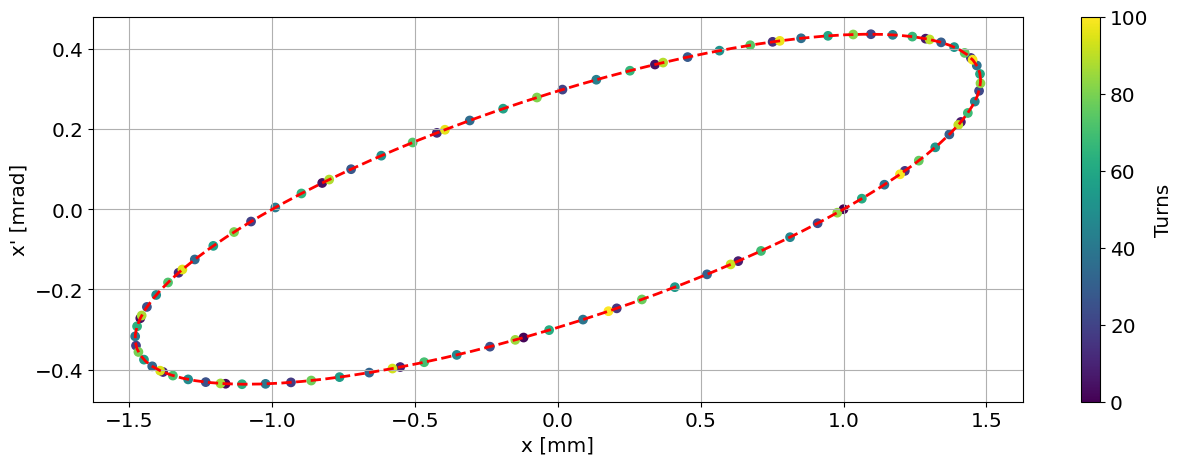

In [372]:
# define our usual FODO cell
f = 2.5
L = 2
fodo_lattice = 5*D(L/10) + Q(f) + 10*D(L/10) + Q(-f) + 5*D(L/10)

# compute the periodic solution
tune, beta, alpha, gamma = twiss(fodo_lattice)

# generate a particle
x = 1
xp = 0
particle = [[x],[xp]]

# compute the associate single-particle emittance of this particle
single_part_emit = particle_emittance(x, xp, beta, alpha)
# get coordinate of an ellipse in phase space with the given parameters
ellipse_coordinates = ellipse_points(single_part_emit, beta, alpha)

# track the particle over 100 cells
OTM = getEquivalentElement(fodo_lattice)
transported_particles = transportParticles(particle,100*OTM)

# plot tracked particles as well as ellipse
plt.plot(ellipse_coordinates[0,:], ellipse_coordinates[1,:],'r--', lw=2)
plt.scatter(transported_particles['x'], transported_particles['xp'], c = transported_particles['s']/(L*2))
cb=plt.colorbar()
cb.set_label('Turns')
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")
plt.grid(True)
    


### Exercise 19
Plot the position of the particle vs the number of turns. What do you observe?
Can you infer the tune? How many turns (or FODO cells) are needed for the particle to complete one full oscillation?

#### SOLUTION

The expected single-cell tune is 0.131.
 => Over 100 one expects to see 13.099 oscillations!


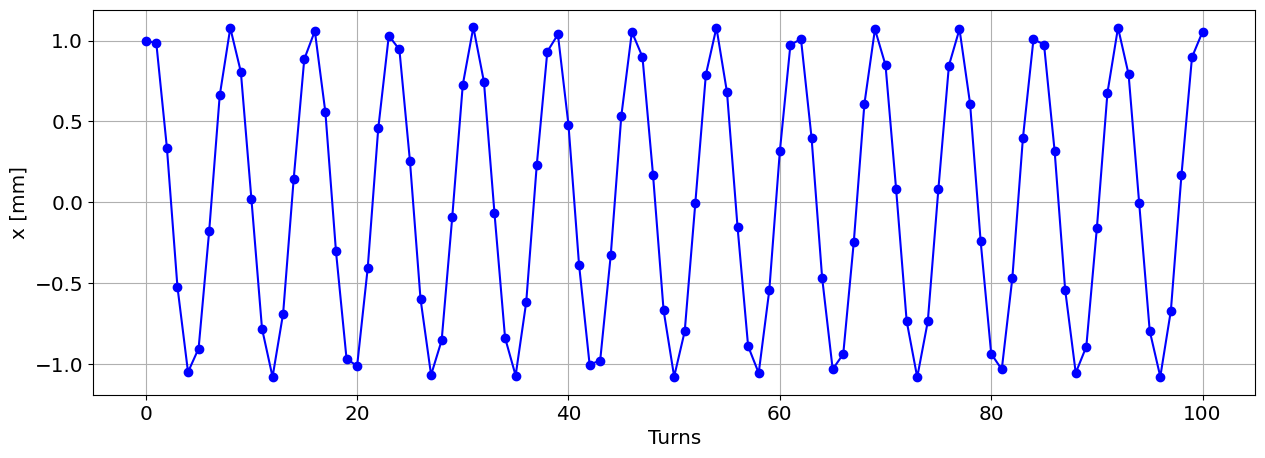

In [377]:
f = 2.5
L_2 = 2
n_turns = 100
fodo_lattice = 5*D(L/10) + Q(f) + 10*D(L/10) + Q(-f) + 5*D(L/10)
OTM = getEquivalentElement(fodo_lattice)
particle = [[1],[.3]]
transported_particles = transportParticles(particle,n_turns*OTM)

plt.plot(transported_particles['s']/(L*2), transported_particles['x'] ,'o-b')
plt.xlabel('Turns')
plt.ylabel('x [mm]')
plt.grid(True)

# let's compute the tune from the OTM
tune, beta, alpha, gamma = twiss(OTM)
print(f'The expected single-cell tune is {tune:.3f}.')
print(f' => Over {n_turns} one expects to see {n_turns*tune:.3f} oscillations!')

We clearly see a betatronic oscillation. And this is true also for x' (se below, and note the different amplitude and phase).

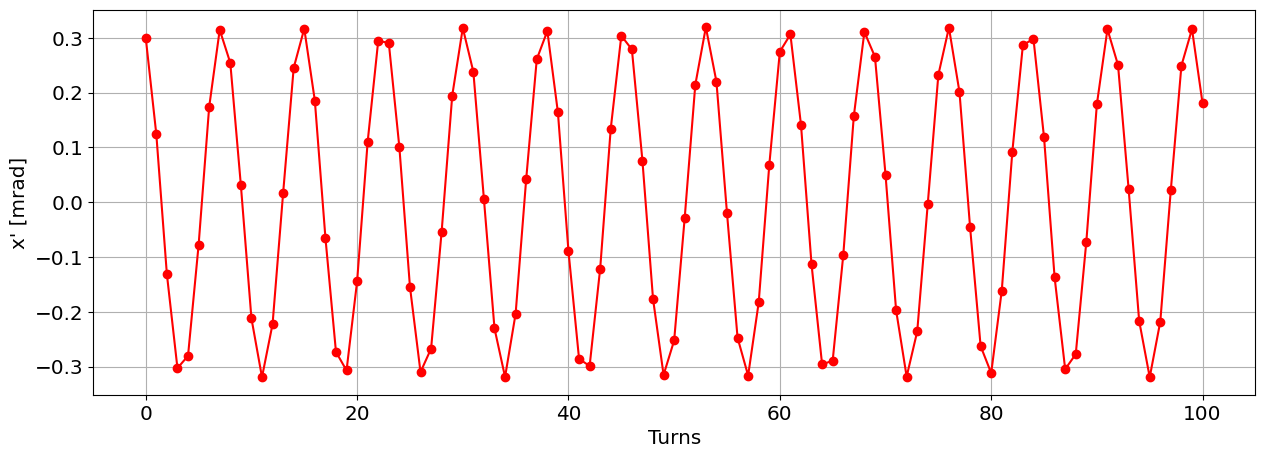

In [46]:
plt.plot(transported_particles['s']/(L_2*2), transported_particles['xp'][0] ,'o-r')
plt.xlabel('Turns')
plt.ylabel("x' [mrad]")
plt.grid(True)

---

# Advanced topics

The following exercises have not been addressed during the course. They are examples that show how one can extend our simple tool to investigate and better understand more complex systems.

# **NOTE: THE CODE OF THE FOLLOWING PART HAS NOT BEEN REVIEWED, YET!**

---

---

## Optics matching

---

### Exercise 27
Vary $f$ by hand and try to (a) find a value that returns Q= 1/6. (b) Then try to find a value of $f$ that produces a 90 deg phase-advance.  What is the corresponding value of Q?

#### SOLUTION

In [56]:
f = 2
L_2 = 2
fodo_lattice = Q(2*f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/10)+Q(2*f)
tune, beta, alpha, gamma = twiss(fodo_lattice)
print(f'The tune is {tune}.')

The tune is 0.16666666666666677.


In [57]:
f = 2/np.sqrt(2)
L_2 = 2
fodo_lattice = Q(2*f) + 10*D(L_2/10) + Q(-f)+10*D(L_2/10) + Q(2*f)
tune, beta, alpha, gamma = twiss(fodo_lattice)
print(f'The tune is {tune}.')

The tune is 0.24999999999999992.


### Exercise 28

A common task when designing accelerators is matching one section of a beam line
to another one. Here we will assume that the upstream beam line consists of
FODO cells with a $60^o$ phase advance and the downstream beam line of FODO cells 
with a $90^o$ phase advance. These are the cells with the focal length we calculated
in Exercise~27. In between the $60^o$ and $90^o,$ we place a third cell with two
quadrupoles that we will use to match the upstream to the downstream beam line.
To do so, we need to prepare periodic beam matrices sigma60 and sigma90 for the respective sections. Note that sigma90 only depends 
on two parameters: the Twiss parameters $\alpha$ and $\beta,$ and therefore we 
also need two quadrupoles with independently variable focal length to adjust
until the final beam matrix equals sigma90.

Implement the procedure described in the previous paragraph and match of a FODO lattice with $\mu$=60 deg and $\mu$=90 deg.

#### SOLUTION

In [58]:
f = 2
L_2 = 2
fodo_lattice = Q(f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/10)
tune, beta, alpha, gamma = twiss(fodo_lattice)
sigma_60 = np.array([[beta, -alpha],[-alpha, gamma]])

In [59]:
f = 2/np.sqrt(2)
L_2 = 2
fodo_lattice = Q(f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/10)
tune, beta, alpha, gamma = twiss(fodo_lattice)
sigma_90 = np.array([[beta, -alpha],[-alpha, gamma]])
sigma_90

array([[6.82842712, 2.41421356],
       [2.41421356, 1.        ]])

In [60]:
# optimization by hand 
L_2 = 2
f1 = 1.62
f2 = 1.45
fodo_lattice = Q(f1) + 10*D(L_2/10) + Q(-f2) + 10*D(L_2/10)
fodo_lattice_compressed = getEquivalentElement(fodo_lattice)
fodo_lattice_compressed[0]['matrix']@sigma_60@(fodo_lattice_compressed[0]['matrix']).transpose()

array([[6.66672256, 2.45256598],
       [2.45256598, 1.05225316]])

In [61]:
# numerical optimisation using scipy.optimize package
from scipy.optimize import minimize
def penalty_function(f):
    fodo_lattice = Q(f[0]) + 10*D(L_2/10) + Q(-f[1]) + 10*D(L_2/10)
    fodo_lattice_compressed = getEquivalentElement(fodo_lattice)
    M = fodo_lattice_compressed[0]['matrix']@sigma_60@(fodo_lattice_compressed[0]['matrix']).transpose() - sigma_90
    return np.linalg.norm(M)

res = minimize(penalty_function, [1.62, 1.45])
res

      fun: 1.0294826992450796e-08
 hess_inv: array([[ 4.98642707e-09, -1.03490872e-09],
       [-1.03490872e-09,  2.47435887e-09]])
      jac: array([3.05779546, 3.27373282])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 192
      nit: 22
     njev: 60
   status: 2
  success: False
        x: array([1.65681256, 1.38987535])

In [62]:
#sanity check
L_2 = 2
f1 = res['x'][0]
f2 = res['x'][1]
fodo_lattice = Q(f1) + 10*D(L_2/10) + Q(-f2) + 10*D(L_2/10)
fodo_lattice_compressed = getEquivalentElement(fodo_lattice)
fodo_lattice_compressed[0]['matrix']@sigma_60@(fodo_lattice_compressed[0]['matrix']).transpose()-sigma_90

array([[9.62939151e-09, 2.55917376e-09],
       [2.55917509e-09, 3.99417721e-10]])

---

## Thick quadrupoles and bends

---

### Exercise 29 

Introduce as a new element the thick quadrupoles matrices.

**Hint**:  write an external function that returns the corresponding list.

#### SOLUTION

In [63]:
def Qthick(k1, l):
    '''Returns a thick quadrupole element'''
    if k1>0:
        matrix = np.array([[np.cos(np.sqrt(k1)*l), 
                          1/np.sqrt(k1)*np.sin(np.sqrt(k1)*l)],
                          [-np.sqrt(k1)*np.sin(np.sqrt(k1)*l), 
                          np.cos(np.sqrt(k1)*l)]])
    else:
        k1 = -k1
        matrix = np.array([[np.cosh(np.sqrt(k1)*l),
                          1/np.sqrt(k1)*np.sinh(np.sqrt(k1)*l)],
                          [np.sqrt(k1)*np.sinh(np.sqrt(k1)*l),
                          np.cosh(np.sqrt(k1)*l)]])
    return  [{'matrix': matrix, 'length': l}]

### Exercise 30

Use the beam line from Exercise 27 (60 degrees/cell FODO) and replace the thin quadrupoles by long quadrupoles with a length of 0.2, 0.4, 1.0 m.  Make sure the overall length and the phase advance of the FODO cell remains unchanged. By how much does the periodic beta function at the start of the cell change? Express the change in percent. 

#### SOLUTION

In [64]:
# Thin lens
f = 2
L_2 = 2
fodo_lattice = Q(f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/(10))
tune, beta, alpha, gamma = twiss(fodo_lattice)
beta_thin = beta

# Thick lenses
for l_quad in [.2, .4, 1.0]:
    l_cell = 4 
    l_drift = (l_cell-2*l_quad)/2
    k1 = 1/f/l_quad
    fodo_lattice = Qthick(k1,l_quad)+10*D(l_drift/10)+Qthick(-k1,l_quad)+10*D(l_drift/(10))
    tune, beta, alpha, gamma = twiss(fodo_lattice)
    print(f'With l_quad={l_quad} m we have a relative error if we assume thin lens approximation of {(beta-beta_thin)/beta_thin}!')

With l_quad=0.2 m we have a relative error if we assume thin lens approximation of -0.02066146254119463!
With l_quad=0.4 m we have a relative error if we assume thin lens approximation of -0.03806428935798469!
With l_quad=1.0 m we have a relative error if we assume thin lens approximation of -0.06766354778275335!


### Exercise 31

Implement in a Python function the element corresponding to the weak focusing of a sector bend.


#### SOLUTION

In [272]:
def B(phi, L):
    '''Returns a list containing a thick bend with and length L'''
    # NB: we return a list with a dict
    # the dict contains the matrix (the transformation)
    # and the element length 

    # compute the 2D bend matrix:
    bend_matrix = np.array(
        [[np.cos(phi),          L/phi*np.sin(phi)],
        [-np.sin(phi)/L*phi,    np.cos(phi)]]
        )

    return [{'matrix':bend_matrix, 'length':L}]
B(.001,1)

[{'matrix': array([[ 9.99999500e-01,  9.99999833e-01],
         [-9.99999833e-07,  9.99999500e-01]]),
  'length': 1}]

### Exercise 32
Insert 1 m long dipoles in the center of the drift spaces of the FODO cells from Exercise 27 while keeping the length of the cell constant. Investigate deflection angles of φ= 5, 10 and 20 degrees.  Check by how much the periodic beta functions change.  Why do they change?   Can you compensate the phase advance $\mu$ by adjusting the strength or focal lengths of the quadrupoles?

#### SOLUTION 

In [66]:
# Thin lens and no dipoles
f = 2
L_2 = 2
pi = np.pi
fodo_lattice = Q(f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/(10))
tune, beta, alpha, gamma = twiss(fodo_lattice)
beta_thin = beta

# Thin lens and  dipoles
for phi in np.array([5,10,20])*pi/180:
    f = 2
    l_cell = 4
    l_dipole = 1
    l_drift = (l_cell-l_dipole*2)/4
    fodo_lattice = Q(f) + D(l_drift) + B(phi,l_dipole) + \
                   D(l_drift) + Q(-f) + D(l_drift) + \
                   B(phi,l_dipole) + D(l_drift)
    tune, beta, alpha, gamma = twiss(fodo_lattice)
    print(f'With phi={phi} m we have a relative error of {(beta-beta_thin)/beta_thin}!')

With phi=0.08726646259971647 m we have a relative error of -0.026504367134691145!
With phi=0.17453292519943295 m we have a relative error of -0.09386135560192685!
With phi=0.3490658503988659 m we have a relative error of -0.25835857726299966!


---

## Energy effects

---

### Exercise 33
Upgrade the software to consistently handle $3\times3$ matrices for drift space, quadrupoles, and sector dipoles, where the third coordinate corresponds to the particle energy deviation $\mathrm{d}p/p_0$.

#### SOLUTION 

In [67]:
def Qthick3(k1, l):
    '''Returns a thick quadrupole element (3x3 case)'''
    if k1>0:
        matrix = np.array([[np.cos(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sin(np.sqrt(k1)*l), 0],\
                         [-np.sqrt(k1)*np.sin(np.sqrt(k1)*l), np.cos(np.sqrt(k1)*l), 0],\
                        [0,0,1]])
    else:
        k1 = -k1
        matrix = np.array([[np.cosh(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sinh(np.sqrt(k1)*l), 0],\
                         [np.sqrt(k1)*np.sinh(np.sqrt(k1)*l), np.cosh(np.sqrt(k1)*l), 0],\
                        [0,0,1]])
    return [{'matrix': matrix, 'length': l}]

In [68]:
# The drift as a sequence of a single tuple
D3 = lambda L: [{'matrix': np.array([[1, L, 0],[0, 1, 0], [0, 0, 1]]), 'length':L}]

# The quadrupole 
Q3 = lambda f: [{'matrix': np.array([[1, 0, 0],[-1/f, 1,0],[0,0,1]]), 'length':0 }]

# The sector bend
B3 = lambda phi, l: [{'matrix': np.array([[np.cos(phi),l/phi*np.sin(phi), l/phi*(1-np.cos(phi))],\
                              [-np.sin(phi)/l*phi, np.cos(phi), np.sin(phi)],
                             [0,0,1]]), 'length': l}]

def R2beta(R):
    # 2x2 case
    if np.shape(R)[0]==2:
        mu = np.arccos(0.5*(R[0,0]+R[1,1]))
        if (R[0,1]<0): 
            mu = 2*np.pi-mu
        Q = mu/(2*np.pi)
        beta = R[0,1]/np.sin(mu)
        alpha = (0.5*(R[0,0]-R[1,1]))/np.sin(mu)
        gamma = (1+alpha**2)/beta
        return (Q, beta, alpha, gamma)
    
    # 3x3 case
    if np.shape(R)[0]==3:
        R = R[:3,:3]
        mu = np.arccos(0.5*(R[0,0]+R[1,1]))
        if (R[0,1]<0): 
            mu = 2*np.pi-mu
        Q = mu/(2*np.pi)
        beta = R[0,1]/np.sin(mu)
        alpha = (0.5*(R[0,0]-R[1,1]))/np.sin(mu)
        gamma = (1+alpha**2)/beta
        return (Q, beta, alpha, gamma)

### Exercise 34
Build a beam line of six FODO cells with a phase advance of 60 degrees/cell (thin quadrupoles are OK to use) and add a sector bending magnet with length 1 m and bending angle $\phi=10$ degrees in the center of each drift. You may have to play with the quadrupole values to make the phase advance close to 60 degrees. But you probably already did this in Exercise 32.

#### SOLUTION

In [69]:
f = 2.26085
l_cell = 4
l_dipole = 1
l_drift = (l_cell-l_dipole*2)/4
phi = 20*pi/360
fodo_lattice = Q3(f) + 3*D3(l_drift/3) + B3(phi,l_dipole) + 3*D3(l_drift/3) + \
               Q3(-f) + 3*D3(l_drift/3) + B3(phi,l_dipole) + 3*D3(l_drift/3)

tune, beta, alpha, gamma = twiss(fodo_lattice)
print(f'''
The tune is: {tune}
The beta is: {beta} m
The alpha is: {alpha} 
The gamma is: {gamma}
''')


The tune is: 0.16666742254599543
The beta is: 6.402756913976354 m
The alpha is: -1.4160065714170231 
The gamma is: 0.4693407309805126



### Exercise 35
Use the starting conditions $(x_0,x_0',\delta)=(0,0,0)$ and plot the position along the beam line. Repeat this for $\delta=10^{-3}$ and for $\delta=3\times 10^{-3}$. Plot all three traces in the same graph. Discuss what you observe and explain.

#### SOLUTION

Text(0, 0.5, 'x [mm]')

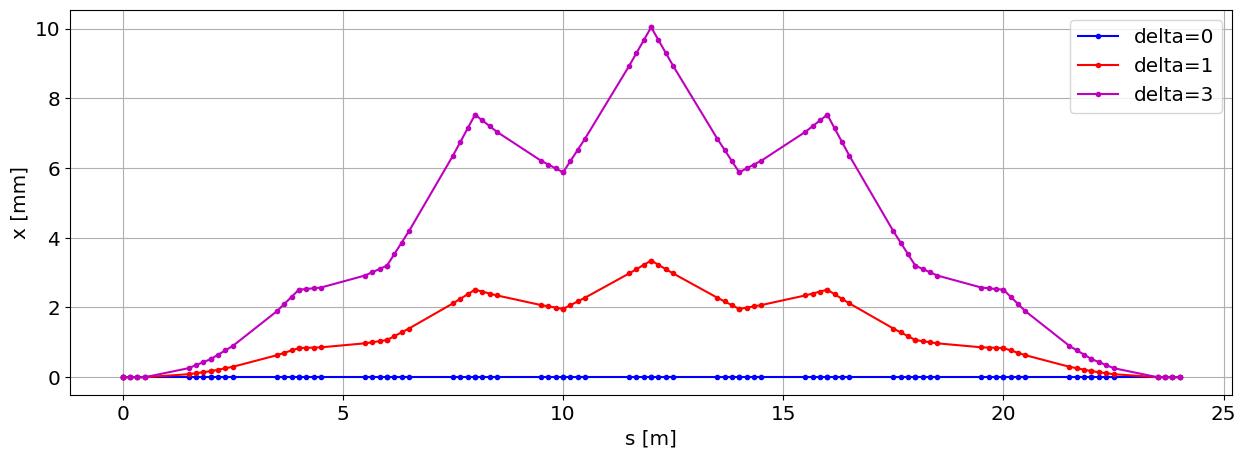

In [70]:
# tracking
for delta,color in zip([0,1, 3],['b','r','m']):
    beam = np.array([[0],[0],[delta]])
    transported_particles = transportParticles(beam, 6*fodo_lattice)
    plt.plot(transported_particles['s'], transported_particles['x'][0], '.-'+color, label=f'delta={delta}')

plt.legend()
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('x [mm]')

### Exercise 36
Work out the transverse components of the periodic beam matrix $\sigma_0$. Assume that the geometrical emittance is $\epsilon_0=10^{-6}$ m rad. Furthermore, assume that the momentum spread $\sigma_0(3,3)=\sigma_p^2$ is zero and plot the beam size along the beam line.

#### SOLUTION

In [71]:
epsilon_0 = 1e-6
sigma_p_2 = 0
sigma_0 = epsilon_0*np.array([[beta, -alpha, 0],[-alpha, gamma,0],[0,0,sigma_p_2]])

Text(0.5, 0, 's [m]')

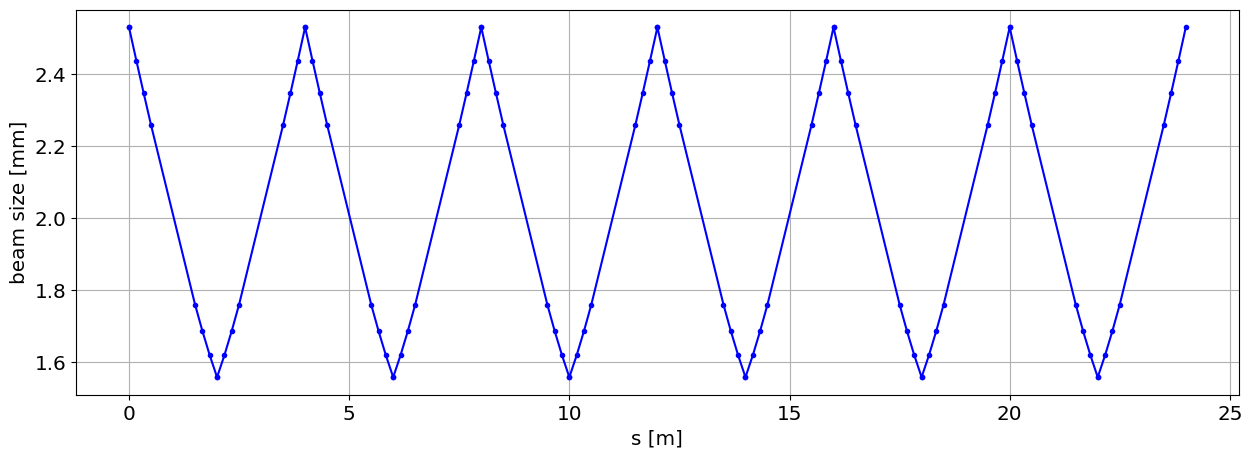

In [72]:
transported_sigmas = transportSigmas(sigma_0, 6*fodo_lattice)
plt.plot(transported_sigmas['s'], np.sqrt(transported_sigmas['sigma11']), '.-b')
plt.grid(True)
plt.ylabel('beam size [mm]')
plt.xlabel('s [m]')

### Exercise 37
Plot the beam size for for $\sigma_p^2=10^{-3}$ and for $\sigma_p^2=3\times 10^{-3}$. What happens if you change the phase advance of the cell? Try out by slightly changing the focal lengths.

#### SOLUTION

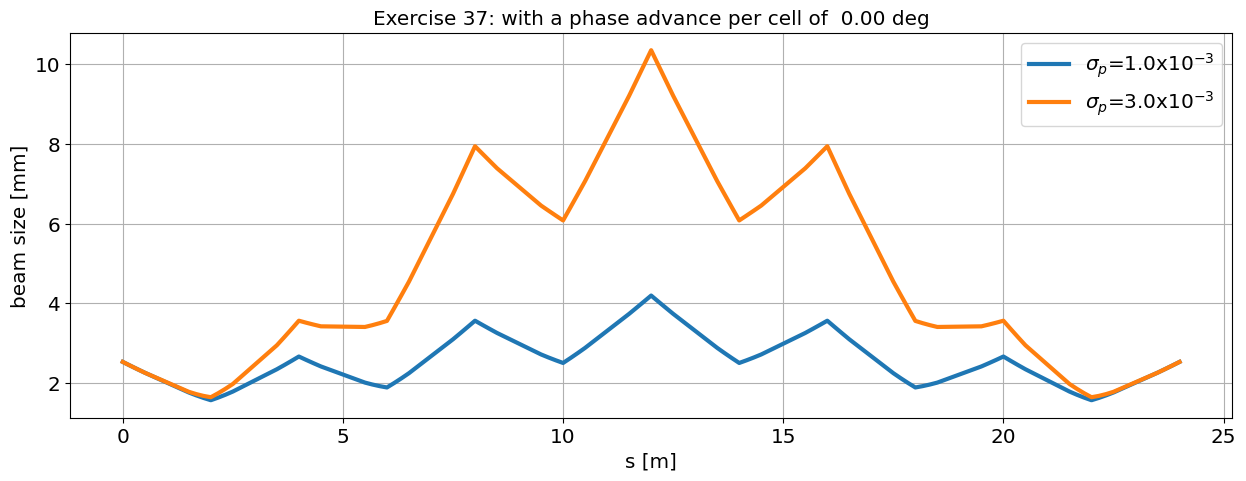

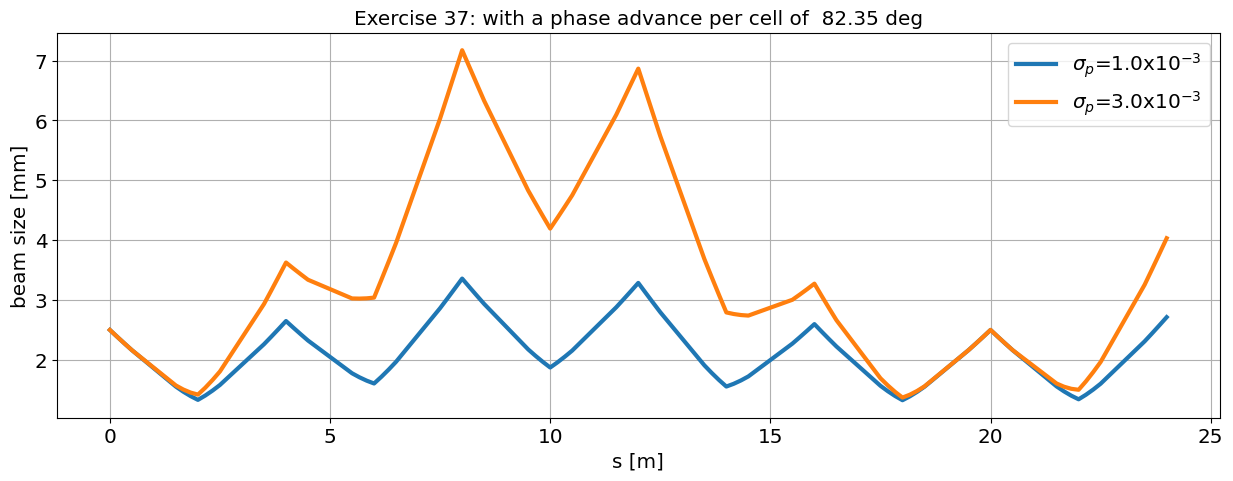

In [73]:
l_cell = 4
l_dipole = 1
l_drift = (l_cell-l_dipole*2)/4
phi = 20*pi/360

for f in [2.26085, 1.8]:
    plt.figure()
    fodo_lattice = Q3(f)+3*D3(l_drift/3)+B3(phi,l_dipole)+3*D3(l_drift/3)+Q3(-f)+3*D3(l_drift/3)+B3(phi,l_dipole)+3*D3(l_drift/3)
    beamline = 6*fodo_lattice
    tune, beta, alpha, gamma = twiss(beamline)
    
    for sigma_p in [1e-3, 3e-3]:
        sigma_p_2 = (sigma_p)**2
        sigma_0 = epsilon_0*np.array([[beta, -alpha, 0],[-alpha, gamma,0],[0,0,sigma_p_2/epsilon_0]])
        transported_sigmas = transportSigmas(sigma_0, 6*fodo_lattice)
        plt.plot(transported_sigmas['s'], np.sqrt(transported_sigmas['sigma11']), label= f'$\sigma_p$={sigma_p}x$10^{{-3}}$', lw=3)

    plt.grid(True)
    plt.ylabel('beam size [mm]')
    plt.xlabel('s [m]')
    plt.title(f'Exercise 37: with a phase advance per cell of {tune*2*180: 3.2f} deg')
    plt.legend(loc='best')

### Exercise 38

Determine the periodic dispersion at the start of the cell. Then plot the dispersion in the cell.

#### SOLUTION

For that we need to find the *real* periodic solution of the 3x3 one turn matrix

In [74]:
OTM = getEquivalentElement(beamline)
eigenvalues, eigenvectors =np.linalg.eig(OTM[0]['matrix'])
print(eigenvalues)
print(eigenvectors[:,2])

[0.13306447+0.99110738j 0.13306447-0.99110738j 1.        +0.j        ]
[0.75524936+0.j 0.20979149+0.j 0.62095567+0.j]


Note that the third eigenvalue is real, i.e. is associated to a real eigenvector, which is our solution:

In [75]:
myDispersion=np.real(eigenvectors[:,2]/eigenvectors[2,2])
print(myDispersion)

[1.21626937 0.3378526  1.        ]


Sanity check: one can see that indeeed is a periodic solution!

In [76]:
OTM[0]['matrix'] @ myDispersion

array([1.21626937, 0.3378526 , 1.        ])

And track it along our lattice:

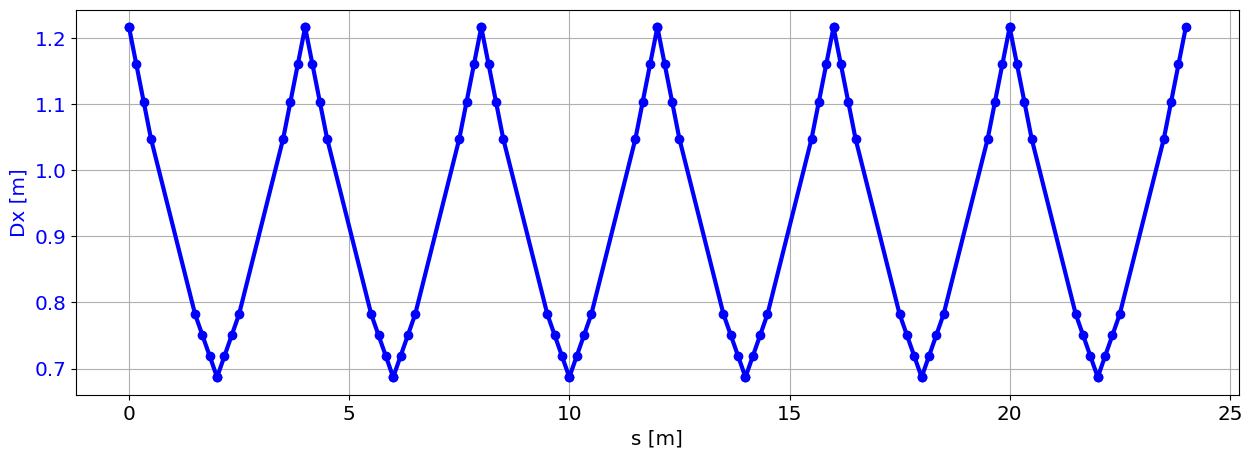

In [77]:
# need to make dispersion array compatible with our transportParticles function
myDispersion = np.reshape(myDispersion, (3,1))
transported_particles = transportParticles(myDispersion, beamline)

plt.plot(transported_particles['s'], transported_particles['x'][0], 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('Dx [m]', color='b')
plt.tick_params(axis='y', labelcolor='b')


### Exercise 39
Convert the code to use $4\times4$ matrices, where the third and fourth columns are associated with the vertical plane. 

#### SOLUTION

In [78]:
# The drift in 4D
D4 = lambda L: [{'matrix': np.array([[1, L, 0, 0],[0, 1, 0, 0], [0, 0, 1, L], [0, 0, 0, 1]]), 'length': L}]

# The quadrupole in 4D
Q4 = lambda f: [{'matrix': np.array([[1, 0, 0, 0],[-1/f, 1, 0, 0],[0, 0, 1, 0],[0, 0, 1/f, 1]]), 'length': 0}]

# The sector bend in 4D
B4 = lambda phi, l: [{'matrix': np.array([[np.cos(phi),l/phi*np.sin(phi), 0, 0],\
                               [-np.sin(phi)/l*phi, np.cos(phi), 0, 0],\
                               [0, 0, 1, l],
                               [0, 0, 0, 1]]),'length': l}]

def twiss(beamline):
    '''Returns the Q, and the Twiss parameters beta, alpha, gamma of the beamline'''
    # 2x2 case
    OTM = getEquivalentElement(beamline)
    R = OTM[0]['matrix']
    
    if np.shape(R)[0]<4:
        mu = np.arccos(0.5*(R[0,0]+R[1,1]))
        if (R[0,1]<0): 
            mu = 2*np.pi-mu
        Q = mu/(2*np.pi)
        beta = R[0,1]/np.sin(mu)
        alpha = (0.5*(R[0,0]-R[1,1]))/np.sin(mu)
        gamma = (1+alpha**2)/beta
        return Q, beta, alpha, gamma

    
    # 4x4 case, we assume uncoupled motion!!!
    if np.shape(R)[0]==4:
        Rx = R[:2,:2]
        mux = np.arccos(0.5*(Rx[0,0]+Rx[1,1]))
        if (Rx[0,1]<0): 
            mux = 2*np.pi-mux
        Qx = mux/(2*np.pi)
        betax = Rx[0,1]/np.sin(mux)
        alphax = (0.5*(Rx[0,0]-Rx[1,1]))/np.sin(mux)
        gammax = (1+alphax**2)/betax
        
        Ry = R[2:,2:]
        muy = np.arccos(0.5*(Ry[0,0]+Ry[1,1]))
        if (Ry[0,1]<0): 
            muy = 2*np.pi-muy
        Qy = muy/(2*np.pi)
        betay = Ry[0,1]/np.sin(muy)
        alphay = (0.5*(Ry[0,0]-Ry[1,1]))/np.sin(muy)
        gammay = (1+alphay**2)/betay
        
        return (Qx, betax, alphax, gammax, Qy, betay, alphay, gammay)
    
# Test
f = 2.
l_cell = 4
l_drift = (l_cell)/2
fodo_lattice = Q4(f) + 10*D4(l_drift/10) + Q4(-f) + 10*D4(l_drift/10)
twiss(fodo_lattice)
print(f'''
The tune is: {tune}
The beta is: {beta} m
The alpha is: {alpha} 
The gamma is: {gamma}
''')


The tune is: 0.2287591328904243
The beta is: 6.235264040046442 m
The alpha is: -1.7320177889017894 
The gamma is: 0.641494184589888



### Exercise 40
Start from a single FODO cell with 60 degrees/cell you used earlier. Insert sector bending magnets with a bending angle of $\phi=10\,$degrees in the center of the drift spaces. The bending magnets will spoil the phase advance in one plane. Now you have two phase advances and need to adjust both quadrupoles (by hand to 2 significant figures) such that it really is 60 degrees in both planes.

#### SOLUTION

In [79]:
l_cell = 4
l_dipole = 1
l_drift = (l_cell-l_dipole*2)/4
phi = 10*pi/360

def computeTunes(f_f,f_d):
    fodo_lattice = Q4(f_f) + D4(l_drift) + B4(phi,l_dipole) + D4(l_drift) + Q4(f_d) + D4(l_drift) + B4(phi,l_dipole) + D4(l_drift)
    Qx, betax, alphax, gammax, Qy, betay, alphay, gammay = twiss(fodo_lattice)
    print(f'Qx = {Qx}')
    print(f'Qy = {Qy}')
    print(f'f_f = {f_f}')
    print(f'f_d = {f_d}')

    
interactive_plot = interactive(computeTunes, f_f=(1.9,2.1,.001), f_d=(-2.1,-1.9,.001), continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '100px'
interactive_plot

interactive(children=(FloatSlider(value=2.0, description='f_f', max=2.1, min=1.9, step=0.001), FloatSlider(val…

In [80]:
computeTunes(2.04,-2.012)

Qx = 0.16679597540775903
Qy = 0.16683496767875342
f_f = 2.04
f_d = -2.012


### Exercise 41

Use the result from exercise 40 and adjust the two quadrupoles such that the phase advance in the horizontal plane is 90 degrees, cell, while it remains 60 degrees/cell in the vertical plane. 

#### SOLUTION

In [81]:
interactive_plot = interactive(computeTunes,f_f=(1.,3,.001),f_d=(-3,-1,.001),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '100px'
interactive_plot

interactive(children=(FloatSlider(value=2.0, description='f_f', max=3.0, min=1.0, step=0.001), FloatSlider(val…

In [82]:
computeTunes(1.491,-1.814)

Qx = 0.25013216769227664
Qy = 0.16677964050295388
f_f = 1.491
f_d = -1.814


### Exercise 42
Prepare a beam line with eight FODO cells without bending magnets and with 60 degrees/cell phase advance in both planes. (a) Prepare the periodic beam  matrix sigma0 (4x4, uncoupled) as the initial beam and plot both beam sizes along the beam line. (b) Use sigma0 as the starting beam, but change the focal length of the second quadrupole by 10\% and plot the beam sizes once again. Discuss you observations.

#### SOLUTION

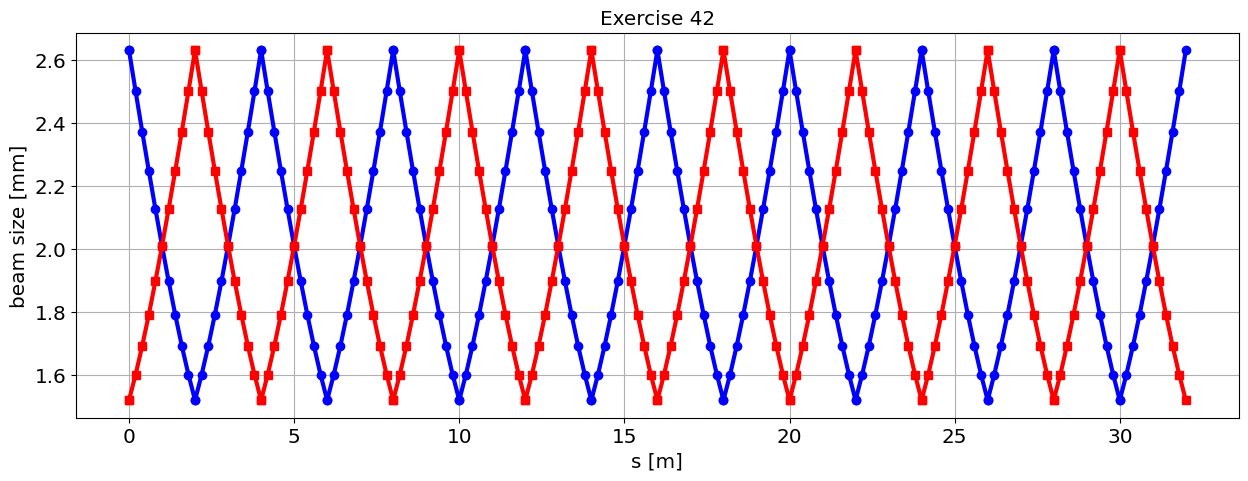

In [83]:
def transportSigmas4D(sigma, beamline):
    coords = [sigma]
    s = [0]
    for element in beamline:
        coords.append(element['matrix'] @ coords[-1] @ element['matrix'].transpose())
        s.append(s[-1] + element['length']) 
    coords = np.array(coords)
    s = np.array(s)
    if len(sigma) < 4:
        return {'sigma11': coords[0][0],
                'sigma12': coords[0][1],
                'sigma21': coords[1][0], # equal to sigma12
                'sigma22': coords[1][1],
                's': s,
                'coords': coords,}
    elif len(sigma)==4:
        return {'sigma11': coords[0][0],
                'sigma12': coords[0][1],
                'sigma21': coords[1][0], # equal to sigma12
                'sigma22': coords[1][1],
                'sigma33': coords[2][2],
                'sigma34': coords[2][3],
                'sigma43': coords[3][2], # equal to sigma34
                'sigma44': coords[3][3],
                's': s,
                'coords': coords,}
        
f = 2.
l_cell = 4
l_drift = (l_cell)/2
fodo_lattice = Q4(f) + 10*D4(l_drift/10) + Q4(-f) + 10*D4(l_drift/10)
beamline = 8*fodo_lattice

Qx, betax, alphax, gammax, Qy, betay, alphay, gammay = twiss(beamline)


epsilon_0 = 1e-6
sigma_0 = epsilon_0*np.array([[betax, -alphax,0, 0],[-alphax, gammax,0,0],
                  [0,0, betay, -alphay],[0,0, -alphay, gammay],
                 ])

transported_sigmas = transportSigmas4D(sigma_0, beamline)
plt.plot(transported_sigmas['s'], np.sqrt(transported_sigmas['sigma11']), 'o-b', lw=3)
plt.plot(transported_sigmas['s'], np.sqrt(transported_sigmas['sigma33']), 's-r', lw=3)
plt.grid(True)
plt.ylabel('beam size [mm]')
plt.xlabel('s [m]')
plt.title('Exercise 42');

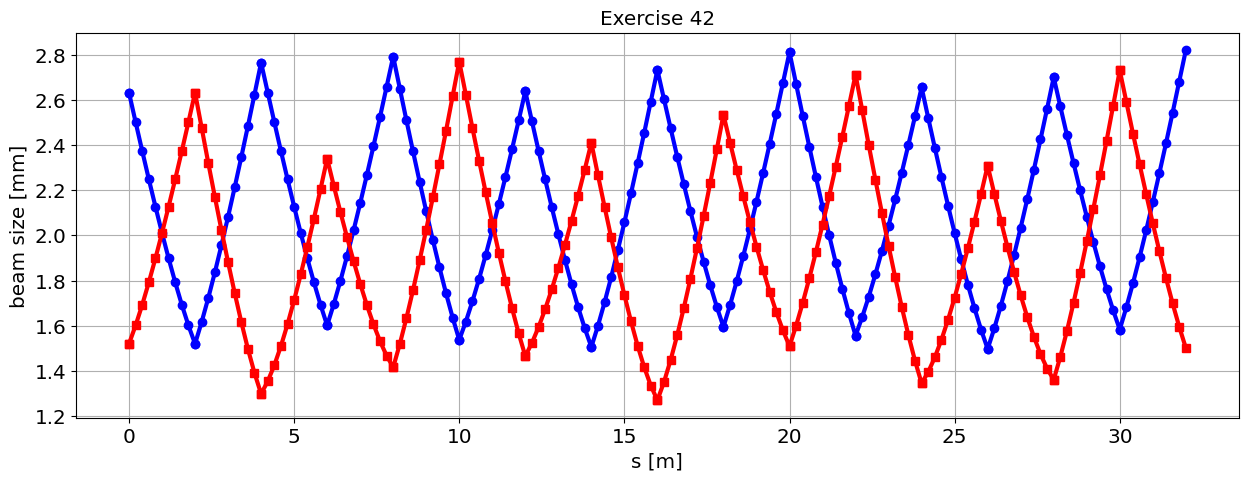

In [84]:
from copy import deepcopy
beamline_new = deepcopy(beamline)
beamline_new[11]['matrix'][1,0] = beamline_new[11]['matrix'][1,0]*1.1
beamline_new[11]['matrix'][3,2] = beamline_new[11]['matrix'][3,2]*1.1

Qx, betax, alphax, gammax, Qy, betay, alphay, gammay = twiss(fodo_lattice)

epsilon_0 = 1e-6
sigma_0 = epsilon_0*np.array([[betax, -alphax,0, 0],[-alphax, gammax,0,0],
                  [0,0, betay, -alphay],[0,0, -alphay, gammay],
                 ])

transported_sigmas = transportSigmas4D(sigma_0, beamline_new)
plt.plot(transported_sigmas['s'], np.sqrt(transported_sigmas['sigma11']), 'o-b', lw=3)
plt.plot(transported_sigmas['s'], np.sqrt(transported_sigmas['sigma33']), 's-r', lw=3)
plt.grid(True)
plt.ylabel('beam size [mm]')
plt.xlabel('s [m]')
plt.title('Exercise 42');

### Exercise 43
From the lecture about betatron coupling identify the transfer matrix for a solenoid and write a function that receives the longitudinal magnetic field $B_s$ and the length of the solenoid as input and returns the transfer matrix.  Then extend the simulation code to handle solenoids. Finally, define a beam line where you place the solenoid in the middle of a FODO cell and follow a particle with initial condition $(x_0,x'_0,y_0,y'_0)=(10^{-3}\,\mathrm{m},0,0,0).$ What do you observe? Is the motion confined to the horizontal plane? 

#### SOLUTION
One has to remember that the matrix is
\begin{equation}
M_{\text {SOLENOID}}=\left(\begin{array}{cccc}{C^{2}} & {\frac{1}{K} S C} & {S C} & {\frac{1}{K} S^{2}}\\
{-K S C} & {C^{2}} & {-K S^{2}} & {S C}\\
{-S C} & {-\frac{1}{K} S^{2}} & {C^{2}} & {\frac{1}{K} S C}\\
{K S^{2}} & {-S C} & {-K S C} & {C^{2}}
\end{array}\right)
\end{equation}
where
\begin{equation}
K=\operatorname{sgn}(\mathrm{q}) \frac{B_{s}}{2(B \rho)}
\end{equation}
and
\begin{equation}
\begin{array}{l}{C=\cos K L} \\ {S=\sin K L}\end{array}
\end{equation}

In [85]:
def solenoid(Bs, L, B_rho, q):
    '''Returns the L-long solenoid element with field Bs 
    normalized to B_rho and to the q polarity.'''
    K = np.sign(q)*Bs/B_rho/2
    C = np.cos(K*L)
    S = np.sin(K*L)
    matrix = np.array([[C**2, S*C/K, S*C, S**2/K],
                     [-K*S*C, C**2, -K*S**2, S*C],
                     [-S*C, -S**2/K, C**2, S*C/K],
                     [K*S**2, -S*C, -K*S*C, C**2]])
    return [{'matrix': matrix,'length': L}]

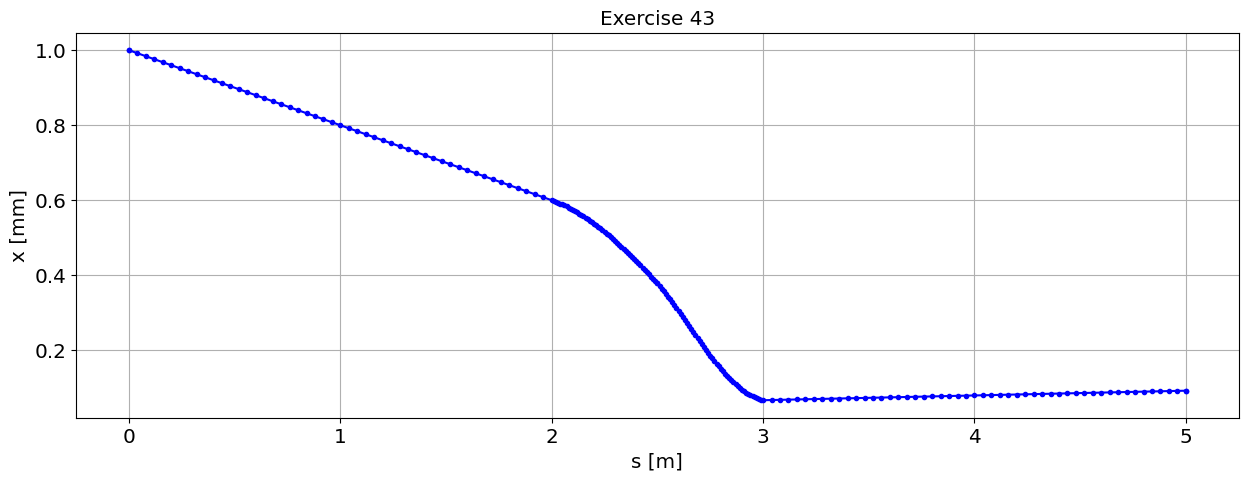

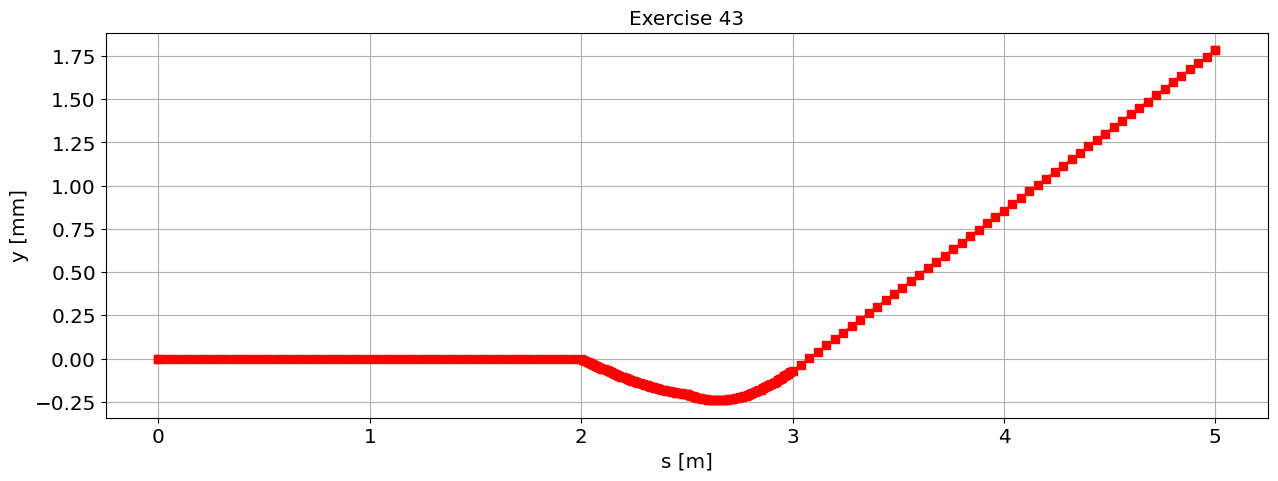

In [86]:
# we need a minor update to the transportParticles
def transportParticles4D(x0,beamline):
    coords = [x0]
    s = [0]
    for elements in beamline:
        coords.append(elements['matrix'] @ coords[-1])
        s.append(s[-1] + elements['length']) 
    coords = np.array(coords).transpose()
    if len(x0)<4:
        return {'x':  coords[:,0,:],
            'xp': coords[:,1,:],
            's':  np.array(s),
            'coords': coords,}
    elif len(x0)==4:
        return {'x':  coords[:,0,:], # [particle_idx, s_idx]
            'xp': coords[:,1,:],     # [particle_idx, s_idx]
            'y':  coords[:,2,:],     # [particle_idx, s_idx]
            'py': coords[:,3,:],     # [particle_idx, s_idx]
            's':  np.array(s),       # [s_idx]
            'coords': coords,}       # [particle_idx, coord_idx, s_idx]

f = 2.5
L_2 = 2
fodo_lattice = Q4(2*f) + 50*D4(L_2/50) + 50*solenoid(.2,.01,.1,1) + Q4(-f) + 50*solenoid(.4,.01,.1,1) + 50*D4(L_2/(50))+Q4(2*f)

beam = np.array([[1],[0],[0],[0]])

output = transportParticles4D(beam, fodo_lattice)

plt.plot(transported_particles['s'], transported_particles['x'][0],'.-b')
plt.xlabel('s [m]')
plt.ylabel("x [mm]")
plt.grid(True)
plt.title('Exercise 43')

plt.figure()
plt.plot(transported_particles['s'], transported_particles['y'][0],'s-r')
plt.xlabel('s [m]')
plt.ylabel("y [mm]")
plt.grid(True)
plt.title('Exercise 43');

One can clearly see that the motion is coupled between the two transverse planes.

---
## Well done! You did all exercises!

Now keep going and explore other concepts that you have encountered during the lectures!

---

In [ ]:
def generateParticles(nparticles, alpha, beta, stdgeoemittance):
    '''
    % [Xs, Angles] = generateParticles(nparticles, alpha, beta, stdgeoemittance)
    % generate nparticles accordingly to given Twiss parameters

    dgamba Sep 2014 (MATLAB)
    dgamba Sep 2022 (Python)
    '''
    # generate cov matrix
    myGamma = (1+alpha^2)/beta
    mySigma = np.array([[beta*stdgeoemittance, -alpha*stdgeoemittance],
                        [-alpha*stdgeoemittance, myGamma*stdgeoemittance]])

    # generate mean array
    myMean = np.array([0, 0])

    # actually generate particles and return coordinates
    (Xs, Angles) = np.random.multivariate_normal(myMean, mySigma, nparticles).T
    return (Xs, Angles)


def generateParticles2D(nparticles, alphaX, betaX, stdgeoemittanceX, alphaY, betaY, stdgeoemittanceY):
    ''' generateParticles2D(nparticles, alphaX, betaX, stdgeoemittanceX, alphaY, betaY, stdgeoemittanceY)
    It generates n particles distribuited accordingly to the given Twiss
    parameters with NO coupling between the two planes.
    
    dgamba Sep 2014 (MATLAB)
    dgamba Sep 2022 (Python)
    '''

    # generate sigma matrices
    myGammaX = (1+alphaX^2)/betaX
    mySigmaX = np.array([[betaX*stdgeoemittanceX, -alphaX*stdgeoemittanceX],
                        [-alphaX*stdgeoemittanceX, myGammaX*stdgeoemittanceX]])

    myGammaY = (1+alphaY^2)/betaY
    mySigmaY = np.array([[betaY*stdgeoemittanceY, -alphaY*stdgeoemittanceY],
                        [-alphaY*stdgeoemittanceY, myGammaY*stdgeoemittanceY]])

    # build sigma matrix
    mySigma = np.zeros(4,4)
    mySigma[0:1,0:1] = mySigmaX
    mySigma[2:3,2:3] = mySigmaY

    # build mean array
    myMean = np.array([0, 0, 0, 0])

    # generate particles
    (Xs, XAngles, Ys, YAngles) = np.random.multivariate_normal(myMean, mySigma, nparticles).T
    return (Xs, XAngles, Ys, YAngles)